<h1 style="color:SteelBlue; font-size:200%">Классификация клиентов банка по их лояльности</h1>

Задача: построить модель для прогноза, уйдёт клиент из банка в ближайшее время или нет. В распоряжении - исторические данные о поведении клиентов и расторжении договоров с банком.

**Признаки:**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
import random

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
#функция построения диаграммы количества пропущенных значений
def NaN_estimation_graph(df, figsize=(8,6)):
    NaN_percent = (100*df.isna().sum()/len(df)).sort_values()
    colors = (NaN_percent  / NaN_percent.max()).tolist()
    colors = [(color, 0.5*(1-color), 0.5*(1-color)) for color in colors] #подготовка градиентной окраски
    plt.figure(figsize=figsize)
    plt.grid(alpha=0.8)
    plt.xticks(range(0,110,10))
    plt.xlim(0,NaN_percent.max()+5)
    plt.xlabel('% пропущенных значений')
    plt.ylabel('признак')
    xpos = NaN_percent + NaN_percent.max()*0.02

    for x, y, txt in zip(xpos, NaN_percent.index, df.isna().sum().sort_values()):
        plt.text(x, y, f'{txt} шт.', verticalalignment='center',
                bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.8)))
    plt.hlines(y=NaN_percent.index, xmin = 0, xmax = NaN_percent, alpha=0.7, 
               linewidth=10, colors=colors)
    plt.suptitle(f'Оценка количества и доли (%) пропусков в данных\nВсего записей: {len(df)}, из них с пропусками:')
    plt.show()

In [3]:
#перестановочные статистические тесты 
#написаны мной в другом проекте, поэтому комментарии на англ. языке
def AB_permutation_test(x, y, par='means', iterations=10000):   
    """
    This is a two-sided permutation test for the null hypothesis that 
    2 samples (x=A and y=B) have identical average values or median values 
    or variances.

    No assumption of the distribution's normality needed
    Samples can be of different sizes, independent or dependent.

    1. The test can be verified by a t-test for the means difference:
    
        scipy.stats.ttest_ind(x,y)
        pvalues should be approximately the same

        Note:
            - normal distributions needed for A, B
            - statistics are different, because 
            in t-test statistic = mean(x)-mean(y)/var(x-y) 
            and in this test statistic = abs(mean(x)-mean(y)) without var(x-y) 

    2. The test can be verified by a Fisher distribution for the variances 
    ratio:
    
        scipy.special.fdtrc(dfn, dfd, f)
        dfn = len(x) - 1
        dfd = len(y) - 1
        f = np.var(x) / np.var(y)
        statistics and pvalues should be approximately the same

        Notes: 
            - normal distributions needed for A, B

    Parameters
    ----------
    
    x : array_like
        A sample.
    
    y : array_like
        B sample.
    
    par : str, optional
        Type of test statistic:
        'means': the absolute difference between the means
        statistic = abs(mean(x) - mean(y))
        
        'medians': the absolute difference between the medians
        statistic = abs(median(x) - median(y))
        
        'variances': the ratio of the variances
        if var(x) > var(y)
        statistic = var(x) / var(y)
        if var(x) < var(y)
        statistic = var(y) / var(x)
        
        The default is 'means'.
    
    iterations : integer, optional
        Number of permutations. The default is 1000.

    Returns
    -------
    named tuple (statistic, iterations, pvalue).
    
    statistic: float
        The computed statistic of the test.
        
        'means_difference' = abs(mean(x) - mean(y))
        'medians_difference' = abs(median(x) - median(y))
        'variances_ratio' = var(x) / var(y)

    itertions: int
        Number of permutations  
        
    pvalue: float
        The two-tailed p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
   
    """
    k = 0
    size_a = len(x)
    a=np.asarray(x) 
    b=np.asarray(y)
    alldata = np.concatenate((a, b))
    
    if par == 'means':
        statistic = 'means_difference'
        diff = np.mean(a) - np.mean(b)
    elif par == 'medians':
        statistic = 'medians_difference'
        diff = np.median(a) - np.median(b)
    elif par == 'variances':
        statistic = 'variances_ratio'
        var_a = np.var(a, ddof=1)
        var_b = np.var(b, ddof=1)
        var_1 = max(var_a, var_b)
        var_2 = min(var_a, var_b)
        diff = var_1 / var_2
    else:
        return "ERROR. Incorrect 'par' value. Use par='means' or 'medians' or 'variances'."
    
    abs_diff = abs(diff)
  
    for i in range (0, iterations):
        np.random.shuffle(alldata) #перемешиваю
        if par == 'means':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'medians':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'variances':
            abs_random_diff = np.var(alldata[:size_a], ddof=1) / np.var(alldata[size_a:], ddof=1)
        
        k += abs_diff < abs_random_diff
        
    pvalue = k / iterations
       
    ABPermutationResult = namedtuple('AB_PermutationResult', (statistic, 'iterations', 'pvalue'))
    
    return ABPermutationResult(diff, iterations, pvalue)


def ANOVA_permutation_test(*args, iterations=10000):
    
    """

    Parameters
    ----------
    *args : sample1, sample2, …: array_like
        The sample measurements for each group.

    iterations : integer, optional
        Number of permutations. The default is 10000.

    Returns
    -------
    
    statistic: float
        The computed F-value of the test.
        
    iterations : int
        Number of permutations.

    pvalue: float
        The associated p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
        
    """
    k = 0
    args = [np.asarray(arg) for arg in args]
    
    alldata = np.concatenate(args)
    mean_alldata = np.mean(alldata)
    
    n_groups = len(args)
    n_alldata = len(alldata)
    
    fbg = n_groups - 1
    fwg = n_alldata - n_groups
    
    SSbg = 0    
    SStotal = np.var(alldata)*n_alldata
    
    size_groups = []
    for arg in args:
        size_groups.append(len(arg))
        SSbg += len(arg)*(mean_alldata - np.mean(arg))**2
    
    SSwg = SStotal - SSbg

    F_orig = (SSbg/fbg) / (SSwg/fwg)
    
    for i in range(0, iterations):
        np.random.shuffle(alldata)
        size_previous = 0
        random_groups = []
        SSbg_random = 0
        
        for size_grp in size_groups:
            random_groups.append(alldata[size_previous : (size_grp+size_previous)])
            size_previous += size_grp
        
        for random_grp in random_groups:
            SSbg_random += len(random_grp)*(mean_alldata - np.mean(random_grp))**2
            
        
        SSwg_random = SStotal - SSbg_random
        F_random = (SSbg_random/fbg) / (SSwg_random/fwg)
        k += F_orig < F_random
    
    pvalue = k / iterations
    
    ANOVAPermutationResult = namedtuple('ANOVA_PermutationResult', ('f_statistic', 'iterations', 'pvalue'))
    
    return ANOVAPermutationResult(F_orig, iterations, pvalue) 

In [4]:
#функции для апсемплинга и даунсэмплинга
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=271828)
    return X_upsampled, y_upsampled

def downsample(X, y, frac):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_zeros = X_zeros.sample(frac=frac, random_state=12345)
    y_zeros = y_zeros.sample(frac=frac, random_state=12345)
    
    X_downsampled = pd.concat([X_zeros] + [X_ones])
    y_downsampled = pd.concat([y_zeros] + [y_ones])
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=271828)
    return X_downsampled, y_downsampled

<h1 style="color:SteelBlue"> 1. Осмотр данных, обработка пропусков и дубликатов</h1>

<h2 style="color:DodgerBlue">1.1 Общая информация, удаление ненужных признаков</h2>

In [5]:
link = 'datasets/Churn.csv'
df = pd.read_csv(link)
df.drop(columns='RowNumber', inplace=True)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


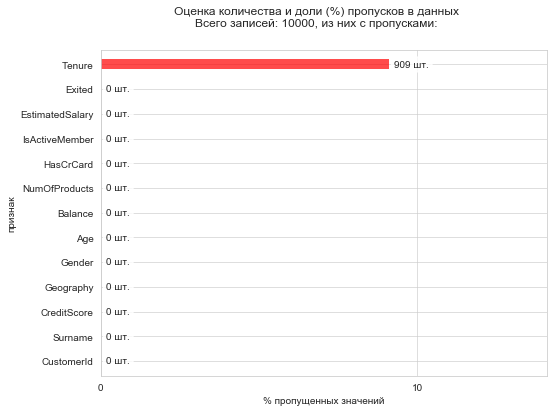

In [7]:
NaN_estimation_graph(df)

In [8]:
print('Число дублей:', df.duplicated().sum())

Число дублей: 0


Всего 13 признаков, 1 целевой - Exited (факт ухода клиента). У 909 объектов отсутствует признак <code>Tenure</code>.
Сомнительна польза признаков <code>CustomerId</code> и <code>Surname</code>. Разве только какие-то клиенты вдруг зарегистрированы не 1 раз (ушёл-вернулся и т.д.), или есть какие-то другие неявные особенности. Проверю.

In [9]:
df['Surname'].value_counts().sort_values(ascending=False)

Smith         32
Martin        29
Scott         29
Walker        28
Brown         26
              ..
Dahlenburg     1
Hopwood        1
Beam           1
Vanzetti       1
Morres         1
Name: Surname, Length: 2932, dtype: int64

In [10]:
df['CustomerId'].value_counts().sort_values(ascending=False)

15695872    1
15652883    1
15752694    1
15656322    1
15712264    1
           ..
15630328    1
15693817    1
15757306    1
15572956    1
15812607    1
Name: CustomerId, Length: 10000, dtype: int64

Популярные фамилии повторяются, id клиентов все уникальные. Вряд ли эта информация может быть полезна в анализе и при построении модели. Удалю признаки <code>'Surname'</code> и <code>'CustomerId'</code>.

In [11]:
df.drop(columns=['Surname', 'CustomerId'], inplace=True)

<h2 style="color:DodgerBlue">1.2 Обработка пропусков</h2>

У 909 объектов отсутствует признак <code>Tenure</code>. Это количество недвижимости у клиента. Возможно, пропуски там, где вообще нет недвижимости. Проверю, отличаются ли объекты с <code>Tenure=NaN</code> от остальных. Посмотрю, есть ли клиенты без недвижимости (Tenure = 0).

In [12]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Заполнение медианой/средним сильно сместит баланс недвижимости. Т.к. количество недвижимости примерно равномерно распределено среди клиентов. Есть 382 клиента с 'Tenure'=0. Т.е. как минимум для части клиентов без недвижимости есть данные об этом. Посмотрю, отличаются ли чем-то клиенты с NaN в Tenure от остальных.

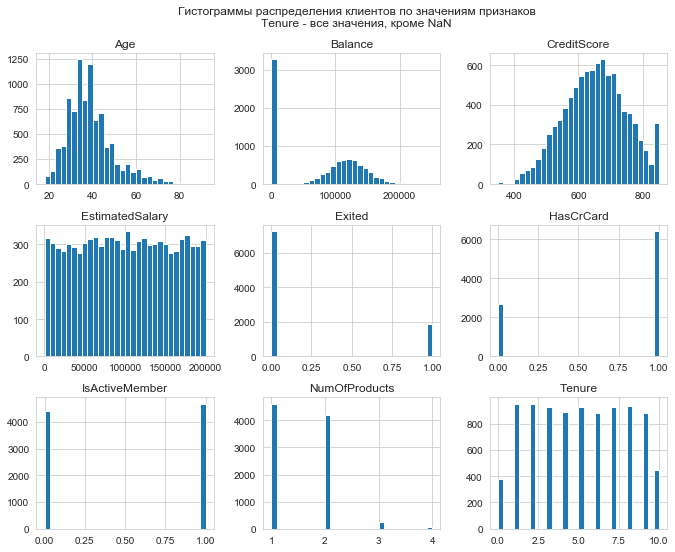

In [13]:
df[~df['Tenure'].isna()].hist(figsize=(10, 10), bins = 30, layout=(4,3))
plt.suptitle('Гистограммы распределения клиентов по значениям признаков\nTenure - все значения, кроме NaN')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

На гистограмме видно, что много клиентов имеют на счету 0. Нужно подробнее разобраться по данному факту.

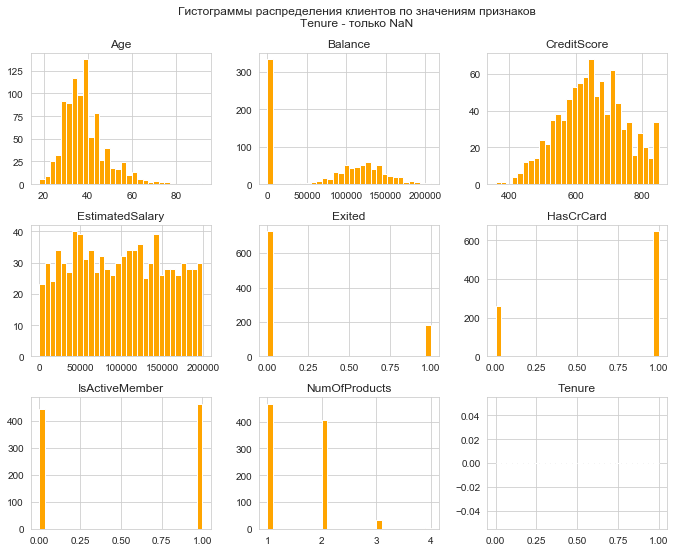

In [14]:
df[df['Tenure'].isna()].hist(figsize=(10, 10), bins = 30, layout=(4,3), color='orange')
plt.suptitle('Гистограммы распределения клиентов по значениям признаков\nTenure - только NaN')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Визуально гистограммы для одних и тех же признаков похожи. <code>EstimatedSalary</code> для <code>Tenure=NaN</code> менее равномерно распределён, но это может быть связано с размером выборки. Проверю, есть ли статистически значимые различия средних значений, медиан и дисперсий признаков между объектами с Tenure = NaN и остальными. Воспользуюсь перестановочным тестом.

**Здесь и далее:**
- Нулевая гипотеза - имеющиеся различия получились случайно. 
- Альтернативная - имеющиеся различия неслучайны. 
- Уровень значимости alpha приму равным 0.05 (если в 5 или более случаях из 100 аналогичные или большие различия получились случайно, принимаем нулевую гипотезу)

In [15]:
numeric = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary']

In [16]:
for feature in numeric:
    t_na = df[df['Tenure'].isna()][feature]
    t_notna = df[~df['Tenure'].isna()][feature]
    print(f'{feature}')
    print(AB_permutation_test(t_na, t_notna))
    print(AB_permutation_test(t_na, t_notna, par='medians'))
    print(AB_permutation_test(t_na, t_notna, par='variances'))

Age
AB_PermutationResult(means_difference=-0.3012157117152725, iterations=10000, pvalue=0.4155)
AB_PermutationResult(medians_difference=0.0, iterations=10000, pvalue=1.0)
AB_PermutationResult(variances_ratio=1.1636002766358038, iterations=10000, pvalue=0.0074)
Balance
AB_PermutationResult(means_difference=-405.3985412524198, iterations=10000, pvalue=0.8515)
AB_PermutationResult(medians_difference=-643.6999999999971, iterations=10000, pvalue=0.7686)
AB_PermutationResult(variances_ratio=1.025060184433886, iterations=10000, pvalue=0.1575)
CreditScore
AB_PermutationResult(means_difference=-2.285507529963297, iterations=10000, pvalue=0.5048)
AB_PermutationResult(medians_difference=-5.0, iterations=10000, pvalue=0.1416)
AB_PermutationResult(variances_ratio=1.0561318934598876, iterations=10000, pvalue=0.1018)
EstimatedSalary
AB_PermutationResult(means_difference=-1000.8255506134883, iterations=10000, pvalue=0.6186)
AB_PermutationResult(medians_difference=-796.179999999993, iterations=10000, p

Статистически значимо различаются дисперсии возраста. Это может быть связано с размерами выборки. По остальным признакам нет оснований отвергать гипотезу о случайном характере различий.

Полагаю, на основании этого анализа можно сделать вывод, что пропуски в <code>Tenure</code> расположены случайно. Поэтому "угадать" их вряд ли получится.

Есть предположение, что количество недвижимости может быть связано с возрастом или доходом. Поэтому перед выбором стратегии заполнения проведу анализ взаимосвязей признаков.

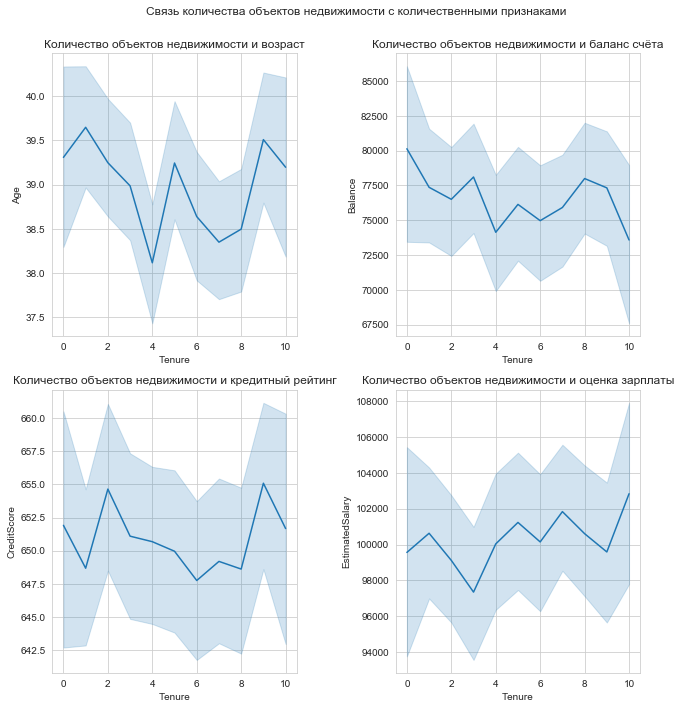

In [17]:
plt.figure(figsize=(10,10))
plt.suptitle("Связь количества объектов недвижимости с количественными признаками")

plt.subplot(221)
sns.lineplot(y='Age', x='Tenure',  data=df)
plt.title("Количество объектов недвижимости и возраст")

plt.subplot(222)
sns.lineplot(y='Balance', x='Tenure',  data=df)
plt.title("Количество объектов недвижимости и баланс счёта")

plt.subplot(223)
sns.lineplot(y='CreditScore', x='Tenure',  data=df)
plt.title("Количество объектов недвижимости и кредитный рейтинг")

plt.subplot(224)
sns.lineplot(y='EstimatedSalary', x='Tenure',  data=df)
plt.title("Количество объектов недвижимости и оценка зарплаты")

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

In [18]:
print('Среднее количество недвижимости', df['Tenure'].mean())
print('Медианное количество недвижимости', df['Tenure'].median())

Среднее количество недвижимости 4.997690023099769
Медианное количество недвижимости 5.0


Есть тенденции "чем выше зарплата, тем больше недвижимости" и "чем больше недвижимости, тем ниже баланс счёта". Хотя коридор, оцененный бутстрапом, очень широкий.

<h2 style="color:DodgerBlue">Итоги обработки пропусков</h2>

У 909 объектов отсутствует признак <code>Tenure</code>. На основании анализа можно сделать вывод, что пропуски в <code>Tenure</code> расположены случайно. 

Поставленная задача является задачей классификации. Для её решения буду использовать модели решающего дерева, случайного леса и логистической регрессии. Для решающего дерева и случайного леса подходит заполнение пропусков нехарактерными значениями. Например, -1000. Для регрессионной модели должно подойти заполнение средним/медианой, оно же годится и для моделей с деревьями. Кроме указанных простых методов [sklearn содержит](https://scikit-learn.org/0.23/modules/impute.html#) классы <code>IterativeImputer</code> и <code>KNNImputer</code>. Первый моделирует каждый признак с пропущенными значениями как функцию от других признаков и использует эту оценку для заполнения. Второй использует алгоритм k-ближайших соседей.

Заполнение медианой/средним сильно сместит баланс недвижимости. Т.к. количество недвижимости примерно равномерно распределено среди клиентов. А заполнение нехарактерными значениями не подойдёт для модели регрессии. Поскольку явных линейных связей количества недвижимости с другими признаками не нашлось, но есть значимые отличия, выглядит логичным вариантом попробовать заполнение методом k-ближайших соседей.

Попробую этот вариант, затем, если понадобится, скорректирую. Заполнение сделаю после завершения анализа данных.

<h1 style="color:SteelBlue"> 2. Ручной анализ данных</h1>

<h2 style="color:DodgerBlue">2.1 Поиск взаимосвязей и различий</h2>

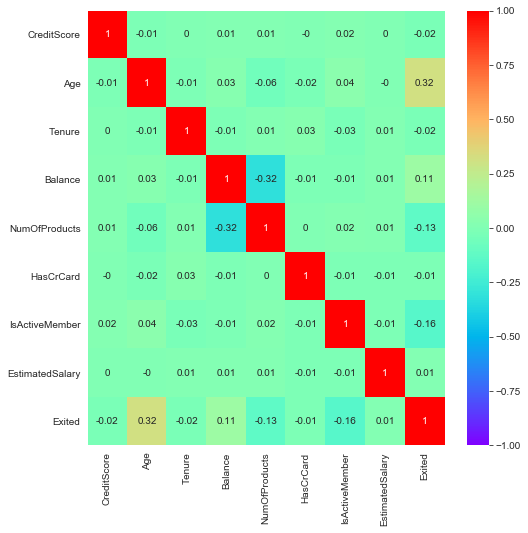

In [19]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(method='spearman').round(2), 
            annot=True, 
            center=0, vmin=-1, vmax=1, 
            cmap='rainbow')
plt.show()

Обнаружилась слабая прямая линейная связь между возрастом и уходом клиента. Слабая обратная линейная связь есть между количеством продуктов банка, используемых клиентом, и балансом его счёта.

Проверю, есть ли значимые различия между средним возрастом ушедших и оставшихся клиентов.

In [20]:
print( AB_permutation_test(df[df['Exited']==1]['Age'], df[df['Exited']==0]['Age']) )

AB_PermutationResult(means_difference=7.429608256300263, iterations=10000, pvalue=0.0)


Средний возраст ушедших клиентов значимо выше, чем средний возраст оставшихся. Есть ли ещё значимые отличия по другим количественным признакам?

In [21]:
for feature in numeric+[]:
    print(feature)
    print(AB_permutation_test(df[df['Exited']==1][feature], df[df['Exited']==0][feature]))
    print(AB_permutation_test(df[df['Exited']==1][feature], df[df['Exited']==0][feature], par='medians'))
    print(AB_permutation_test(df[df['Exited']==1][feature], df[df['Exited']==0][feature], par='variances'))
    

Age
AB_PermutationResult(means_difference=7.429608256300263, iterations=10000, pvalue=0.0)
AB_PermutationResult(medians_difference=9.0, iterations=10000, pvalue=0.0)
AB_PermutationResult(variances_ratio=1.075926493372588, iterations=10000, pvalue=0.0551)
Balance
AB_PermutationResult(means_difference=18363.242558408485, iterations=10000, pvalue=0.0)
AB_PermutationResult(medians_difference=17276.61, iterations=10000, pvalue=0.0)
AB_PermutationResult(variances_ratio=1.1596878048792598, iterations=10000, pvalue=0.0)
CreditScore
AB_PermutationResult(means_difference=-6.5016987316954555, iterations=10000, pvalue=0.0064)
AB_PermutationResult(medians_difference=-7.0, iterations=10000, pvalue=0.0042)
AB_PermutationResult(variances_ratio=1.0999761409457898, iterations=10000, pvalue=0.0007)
EstimatedSalary
AB_PermutationResult(means_difference=1727.2857587371254, iterations=10000, pvalue=0.2295)
AB_PermutationResult(medians_difference=2815.800000000003, iterations=10000, pvalue=0.052)
AB_Permutat

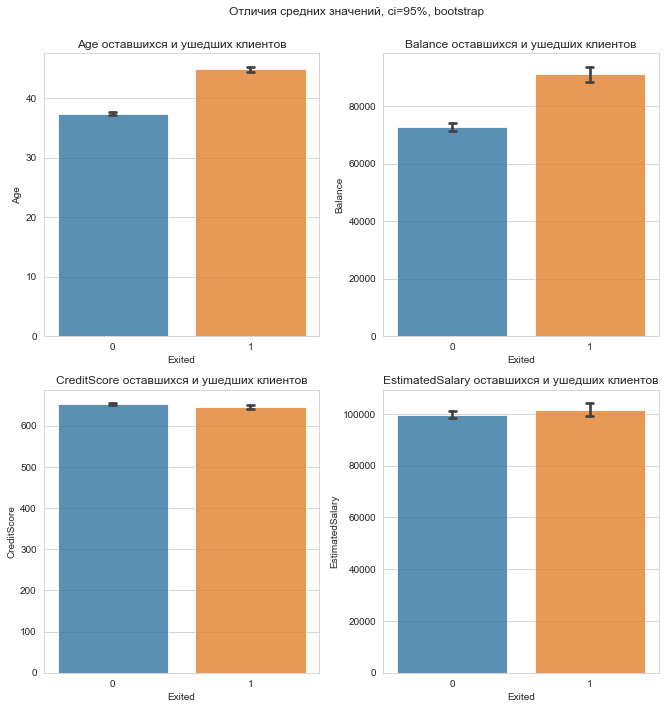

In [22]:
plt.figure(figsize=(10,10))
plt.suptitle('Отличия средних значений, ci=95%, bootstrap')
i = 1
for feature in numeric:
    plt.subplot(2,2,i)
    i+=1
    sns.barplot(x='Exited', y=feature, data=df, ci=95, capsize=.05, alpha=0.8)
    plt.title(f'{feature} оставшихся и ушедших клиентов')

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

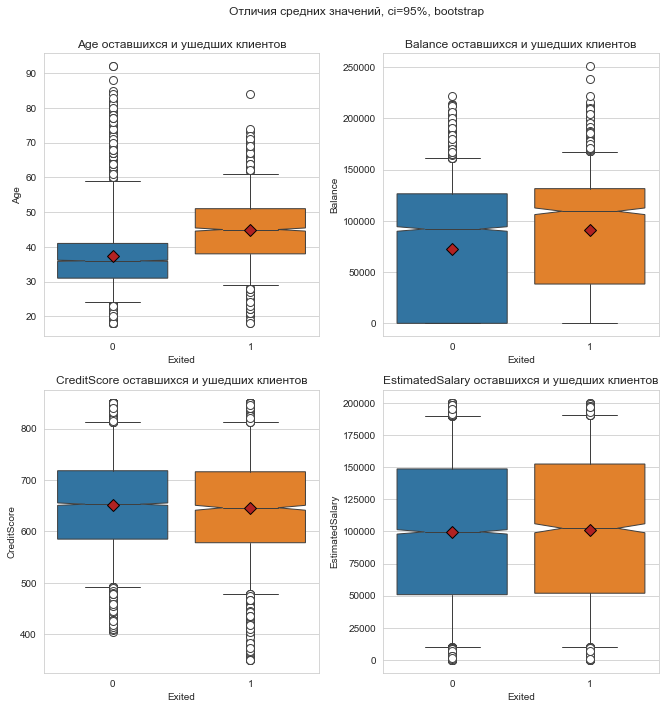

In [23]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markersize=8, markerfacecolor='firebrick')

flierprops = dict(marker='o', markerfacecolor='w', markersize=8,
                  linestyle='none')

plt.figure(figsize=(10,10))
plt.suptitle('Отличия средних значений, ci=95%, bootstrap')
i = 1
for feature in numeric:
    plt.subplot(2,2,i)
    i+=1
    sns.boxplot(x='Exited', y=feature, data=df,
                showmeans=True, notch=True, 
                meanprops=meanpointprops, flierprops=flierprops, 
                linewidth=1, whis=(5,95))
    plt.title(f'{feature} оставшихся и ушедших клиентов')

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Ушедшие клиенты значимо отличаются от оставшихся почти по всем количественным признакам (их средним, медианам и дисперсиям). Наиболее явные отличия - в возрасте и балансе на счёте. Из банка уходят клиенты с более высоким средним балансом и возрастом.

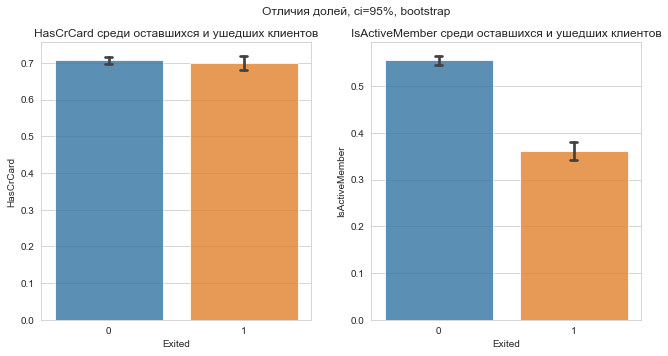

In [24]:
plt.figure(figsize=(10,5))
plt.suptitle('Отличия долей, ci=95%, bootstrap')
i = 1
for feature in ['HasCrCard', 'IsActiveMember']:
    plt.subplot(1,2,i)
    i+=1
    sns.barplot(x='Exited', y=feature, data=df, estimator=np.mean, ci=95, capsize=.05, alpha=0.8)
    plt.title(f'{feature} среди оставшихся и ушедших клиентов')
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Видно, что среди ушедших клиентов была ниже доля активных клиентов. А клиентов с кредитными картами и среди ушедших и среди оставшихся - поровну.

Посмотрим на распределение ушедших и оставшихся клиентов по числу продуктов банка, которым они пользовались

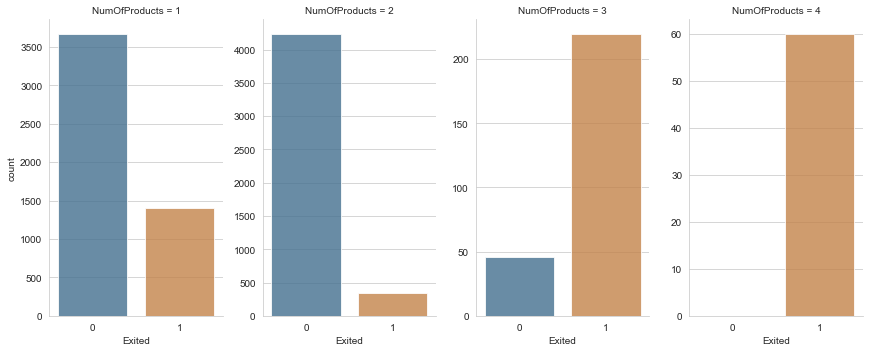

In [25]:
ax=sns.catplot(x="Exited", col="NumOfProducts",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

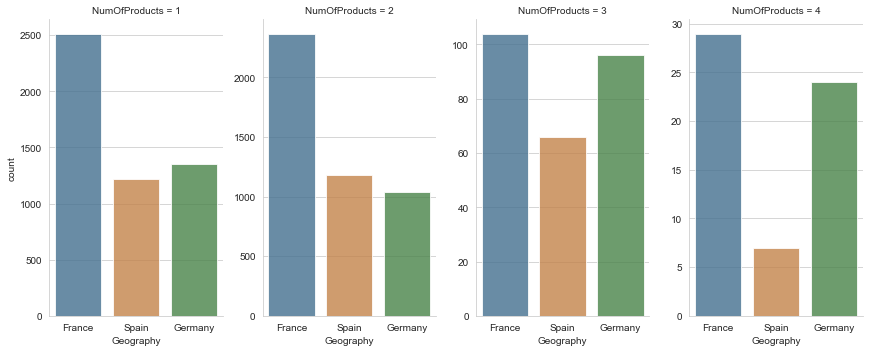

In [26]:
ax=sns.catplot(x="Geography", col="NumOfProducts",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

Среди тех, кто пользовался 4 продуктами банка, вообще никого не осталось. Среди тех, кто пользуется 3 продуктами, осталось мало клиентов. А вот из тех, кто пользовался двумя продуктами, почти никто не ушёл. Возможно, есть какие-то проблемы с этими продуктами банка, нужно анализировать эту проблему подробнее. 4мя продуктами менее всего пользовалось граждан Испании.

Кстати, кого больше среди клиентов банка, испанцев, французов или немцев?

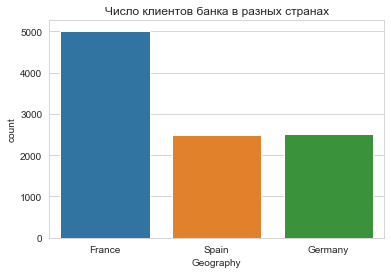

In [27]:
plt.title('Число клиентов банка в разных странах')
sns.countplot(x='Geography', data=df)
plt.show()

Посмотрим на распределение ушедших и оставшихся клиентов по стране проживания

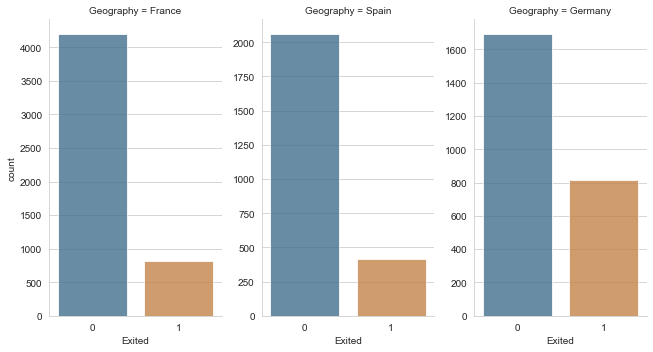

In [28]:
ax=sns.catplot(x="Exited", col="Geography",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

В Германии отток клиентов выше. Доля ушедших клиентов там более чем в 2 раза выше, чем во Франции и Испании.

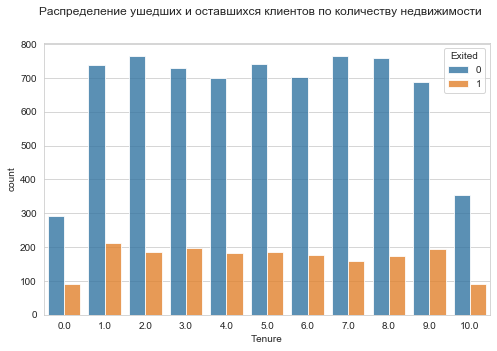

In [29]:
plt.figure(figsize=(8,5))
plt.suptitle('Распределение ушедших и оставшихся клиентов по количеству недвижимости')
sns.countplot(x='Tenure', data=df, hue='Exited', alpha=0.8)
plt.show()

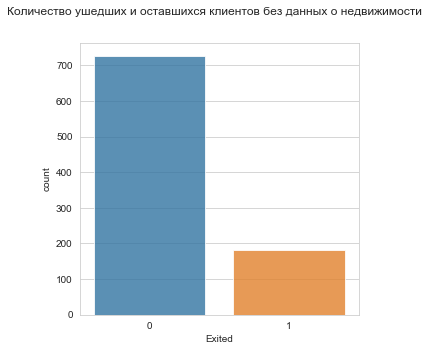

In [30]:
plt.figure(figsize=(5,5))
plt.suptitle('Количество ушедших и оставшихся клиентов без данных о недвижимости')
sns.countplot(x='Exited', data=df[df['Tenure'].isna()], alpha=0.8)
plt.show()

По числу объектов недвижимости ушедшие и оставшиеся клиенты распределены примерно одинаково и равномерно.

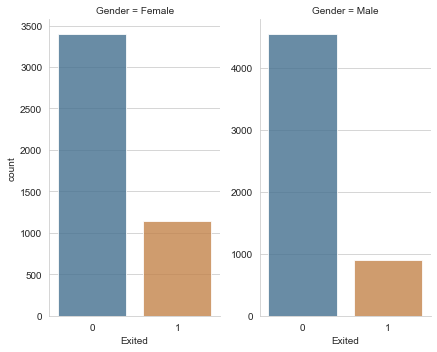

In [31]:
ax=sns.catplot(x="Exited", col="Gender",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

Среди клиентов-женщин доля ушедших почти в 2 раза больше, чем мужчин

<h2 style="color:DodgerBlue">Итоги поиска взаимосвязей и различий</h2>

- между возрастом и уходом клиента есть слабая прямая линейная связь (коэффициент корреляции спирмена 0.32)
- ушедшие клиенты значимо отличаются от оставшихся почти по всем количественным признакам (кроме оценочной заработной платы). Наиболее явные отличия - в среднем возрасте и среднем балансе на счёте. Средний возраст и баланс счёта ушедших клиентов больше, чем оставшихся
- среди ушедших клиентов ниже доля активных клиентов. А доли клиентов с кредитными картами и среди ушедших и среди оставшихся почти равны.
- все клиенты, которые пользовались 4 продуктами банка, ушли. Также ушло большинство (более 80%) из тех, кто пользовался тремя продуктами. Минимальный отток среди пользователей двух продуктов. Вероятно, банку стоит проанализировать, что за продукты не устроили ушедших клиентов.
- В Германии отток клиентов выше. Доля ушедших клиентов там более чем в 2 раза выше, чем во Франции и Испании. Также среди женщин доля ушедших почти в 2 раза больше, чем среди мужчин

Найденные различия указывают, что есть предпосылки для построения качественной модели. Наиболее значимые признаки: Age, Balance, CreditScore, IsActiveMember, NumOfProducts, Geography, Gender.

Может быть проблемой, что все клиенты, пользовавшиеся 4 продуктами банка, ушли. Является ли этот признак действительно столь решающим и критически важным? Модель, вероятно, выделит его. Однако, если условия пользования продуктами будут скорректированы на стороне заказчика, модель также потребует корректировки.

<h2 style="color:DodgerBlue">2.2 Нулевой баланс счёта</h2>

Среди клиентов много тех, у кого баланс счёта равен нулю. Изучу эту группу, нет ли здесь какой-то ошибки.

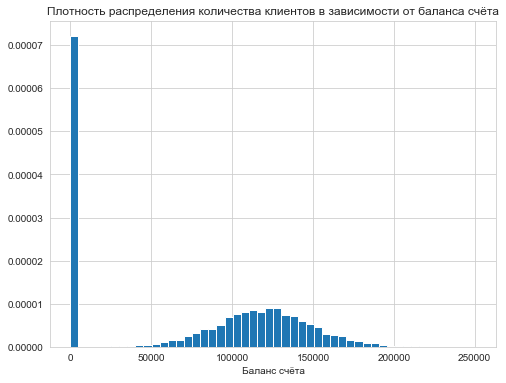

In [32]:
plt.figure(figsize=(8,6))
df['Balance'].hist(bins=50, density=True)
plt.xlabel('Баланс счёта')
plt.title('Плотность распределения количества клиентов в зависимости от баланса счёта')
plt.show()

In [33]:
zero_balance = df[df['Balance']==0]['Balance'].count()
positive_balance = df[df['Balance']>0]['Balance'].count()
print('Клиентов с нулевым балансом счёта:', zero_balance)
print('Клиентов с деньгами на счёте:', positive_balance)
print(f'Доля клиентов с нулевым балансом счёта: {zero_balance/df.shape[0]:.1%}')

Клиентов с нулевым балансом счёта: 3617
Клиентов с деньгами на счёте: 6383
Доля клиентов с нулевым балансом счёта: 36.2%


Более трети клиентов выборки не хранят в банке деньги. Странно. Введу новый признак <code>'IsZeroBalance'</code>. Если баланс равен 0, значение будет 1, если баланс выше нуля - 0.

In [34]:
df.loc[:, 'IsZeroBalance'] = 0
df.loc[df.loc[:, 'Balance'] == 0, 'IsZeroBalance'] = 1

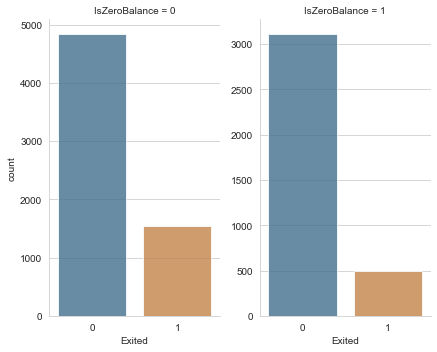

In [35]:
ax=sns.catplot(x="Exited", col="IsZeroBalance",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

Среди клиентов с нулевым балансом доля ушедших ниже, чем среди тех, у кого положительный баланс. Кто меньше пользуется услугами банка, тот реже уходит..

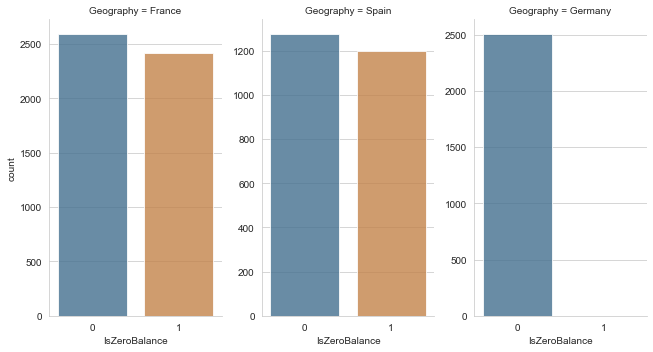

In [36]:
ax=sns.catplot(x="IsZeroBalance", col="Geography",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

В Германии вообще нет клиентов с нулевым балансом! А в Испании и Франции их доля почти равна доле клиентов с положительным балансом. Видимо, поэтому в Германии больше уходов: там нет тех, кто не пользуется услугами банка, и недовольных клиентов больше.

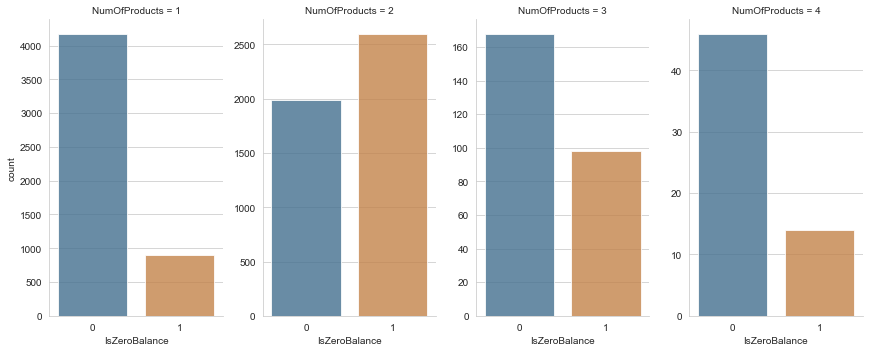

In [37]:
ax=sns.catplot(x="IsZeroBalance", col="NumOfProducts",
                data=df, saturation=.5,
                kind="count", ci=None, aspect=.6, sharey=False, alpha=0.8)

А вот и возможная причина, почему клиенты, пользующиеся двумя услугами банка, меньше всего уходят. У большинства из них нет денег на счёте.

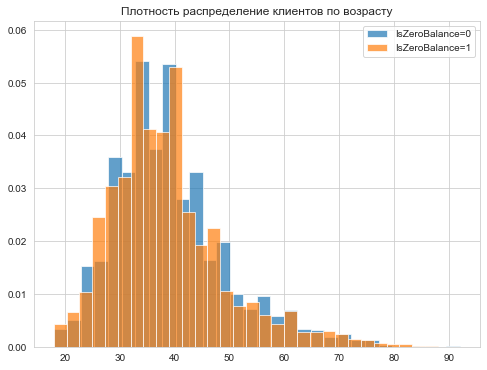

In [38]:
plt.figure(figsize=(8,6))
plt.title('Плотность распределение клиентов по возрасту')
plt.hist(df.loc[df.loc[:, 'IsZeroBalance'] == 0, 'Age'], bins = 30, 
         density=True, label='IsZeroBalance=0', alpha=0.7)
plt.hist(df.loc[df.loc[:, 'IsZeroBalance'] > 0, 'Age'], bins = 30, 
         density=True, label='IsZeroBalance=1', alpha=0.7)
plt.legend()
plt.show()

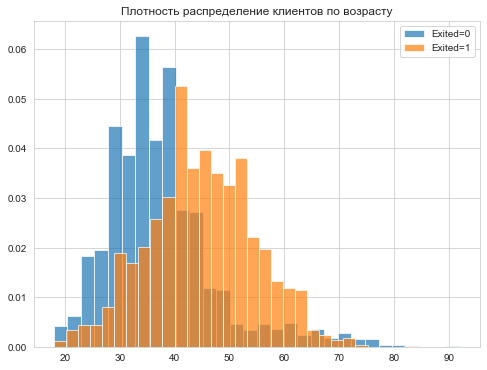

In [39]:
plt.figure(figsize=(8,6))
plt.title('Плотность распределение клиентов по возрасту')
plt.hist(df.loc[df.loc[:, 'Exited'] == 0, 'Age'], bins = 30, 
         density=True, label='Exited=0', alpha=0.7)
plt.hist(df.loc[df.loc[:, 'Exited'] > 0, 'Age'], bins = 30, 
         density=True, label='Exited=1', alpha=0.7)
plt.legend()
plt.show()

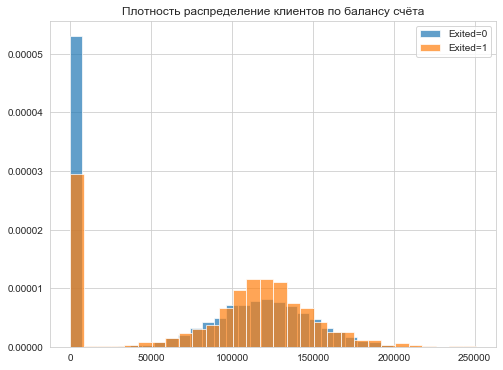

In [40]:
plt.figure(figsize=(8,6))
plt.title('Плотность распределение клиентов по балансу счёта')
plt.hist(df.loc[df.loc[:, 'Exited'] == 0, 'Balance'], bins = 30, 
         density=True, label='Exited=0', alpha=0.7)
plt.hist(df.loc[df.loc[:, 'Exited'] > 0, 'Balance'], bins = 30, 
         density=True, label='Exited=1', alpha=0.7)
plt.legend()
plt.show()

Распределение по возрастам похожи как у клиентов с деньгами на счёте, так и без них. Чего нельзя сказать о распределении по возрастам ушедших и оставшихся клиентов. А также о распределении по балансу счёта. Видимо, возраст и наличие денег на счёте -  признаки независимые, причём оба отличаются для клиентов ушедших и оставшихся.

<h2 style="color:DodgerBlue">Итоги анализа нулевого баланса счёта</h2>

Создал новый признак <code>'IsZeroBalance'</code>. Если баланс равен 0, значение будет 1, если баланс выше нуля - 0. С его помощью выяснил, что:

- Более трети клиентов выборки не хранят в банке деньги
- Все эти клиенты - из Франции и Испании
- Среди клиентов, у которых нет денег на счёте, меньше доля уходов
- Среди клиентов, пользующихся двумя продуктами банка, больше тех, у кого нет денег на счёте.

Если признак помог при ручном анализе, может быть полезен и при моделировании. Однако его можно получить из признака 'Balance', поэтому в модели, вероятно, нужно использовать что-то одно.

<h1 style="color:SteelBlue"> Обобщённые итоги ручного анализа данных</h1>

Все клиенты, которые пользовались 4 продуктами банка, ушли. Также ушло большинство (более 80%) из тех, кто пользовался тремя продуктами. Минимальный отток среди пользователей двух продуктов. Вероятно, банку стоит проанализировать, что за продукты не устроили ушедших клиентов.

Ушедшие клиенты значимо отличаются от оставшихся почти по всем количественным признакам (кроме оценочной заработной платы), наиболее явные отличия - в среднем возрасте и балансе на счёте.


- **между возрастом и уходом клиента есть слабая прямая линейная связь (коэффициент корреляции спирмена 0.32)**; распределения клиентов по возрасту в группах "ушедшие" и "оставшиеся" существенно различаются, есть и статистически значимые отличия; **средний возраст ушедших клиентов выше, чем оставшихся**
- **средний баланс счёта ушедших клиентов выше, чем оставшихся**
- **cреди клиентов, у которых нет денег на счёте, меньше доля уходов**
- **среди клиентов с деньгами на счёте доля ушедших выше, чем оставшихся, в диапазоне 100-130 тыс**
- **среди ушедших клиентов доля активных - ниже, чем среди оставшихся**
- доли клиентов с кредитными картами и среди ушедших и среди оставшихся почти равны
- В Германии отток клиентов выше. Доля ушедших клиентов там более чем в 2 раза выше, чем во Франции и Испании. 
- среди клиентов-женщин доля ушедших больше, чем среди клиентов-мужчин

Найденные различия указывают, что есть предпосылки для построения качественной модели. 

Наиболее значимые признаки: <code>['Age', 'Balance/IsZeroBalance', 'NumOfProducts', 'IsActiveMember', 'Geography', 'Gender', 'CreditScore']</code>.

Может быть проблемой, что все клиенты, пользовавшиеся 4 продуктами банка, ушли. Является ли этот признак действительно столь решающим и критически важным? Модель, вероятно, выделит его. Однако, если условия пользования продуктами будут скорректированы на стороне заказчика, модель также потребует корректировки.

<h1 style="color:SteelBlue"> 3. Подготовка данных</h1>

<h2 style="color:DodgerBlue">3.1 Кодирование признаков</h2>

Планирую использовать как древесные модели, там и регрессию. Уникальных значений признаков не очень много, воспользуюсь прямым кодированием OHE для обоих вариантов. Чтобы избежать мультиколлинеарности, дамми-ловушки, использую <code>drop_first = True</code>.

In [41]:
df = pd.get_dummies(df, drop_first=True)

In [42]:
display(df.shape)
display(df.head())

(10000, 13)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsZeroBalance,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,0


<h2 style="color:DodgerBlue">3.2 Разбиение выборки</h2>

В данных 10000 объектов и рабиение 60-20-20 может быть недостаточным для обучения. Использую разбиение 70-15-15. Оставлю в признаках <code>и 'IsZeroBalance', и 'Balance'</code>, посмотрю уже в моделях, какой лучше работает.

In [43]:
X = df.drop(columns=['Exited'])

In [44]:
y = df['Exited']

In [45]:
display(X.shape)
X.head()

(10000, 12)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsZeroBalance,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,1,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [46]:
display(y.shape)
y.head()

(10000,)

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [47]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=2718,
                                                            stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, 
                                                test_size=0.5, 
                                                random_state=2718,
                                                stratify=y_val_test)

In [48]:
X_train.shape, X_val_test.shape, X_val.shape, X_test.shape

((7000, 12), (3000, 12), (1500, 12), (1500, 12))

In [49]:
y.value_counts(), y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(0    7963
 1    2037
 Name: Exited, dtype: int64,
 0    5574
 1    1426
 Name: Exited, dtype: int64,
 0    1194
 1     306
 Name: Exited, dtype: int64,
 0    1195
 1     305
 Name: Exited, dtype: int64)

<h2 style="color:DodgerBlue">3.3 Заполнение пропусков</h2>

Вообще, похоже, что признак 'Tenure' не очень важен для ответа на вопрос, есть ли риск уходя клиента, или нет.

### Выбор метода заполнения

Сравню заполнение <code>KNNImputer</code> и <code>IterativeImputer</code>. При необходимости далее попробую другие методы. Число соседей выбрал 5. Веса установил зависящими от расстояния, иначе заполнение будет походить на заполнение средним, т.к. распределение количества жилплощади равномерное по выборке. Также для последующего сравнения добавил <code>IterativeImputer</code> (аналогично KNN для этого метода заменил дефолтную mean стратегию на <code>initial_strategy='most_frequent'</code>).

In [50]:
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
iter_imputer = IterativeImputer(max_iter=5, 
                                random_state=123, 
                                imputation_order='random',
                                initial_strategy='most_frequent')
df_knn = knn_imputer.fit_transform(df)
df_iter = iter_imputer.fit_transform(df)

In [51]:
columns = df.columns.tolist()
#columns.append('NaN_flag')
print(columns)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'IsZeroBalance', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


Поскольку заполнение проводилось методом ближайших соседей, признак <code>'Tenure'</code> нужно округлить и перевести в целочисленный тип.

In [52]:
df_knn = pd.DataFrame(data=df_knn, columns=columns)
df_iter = pd.DataFrame(data=df_iter, columns=columns)

In [53]:
df_knn['Tenure'] = df_knn['Tenure'].round(0).astype(int)
df_iter['Tenure'] = df_iter['Tenure'].round(0).astype(int)

In [54]:
df_knn['Tenure'].value_counts()

5     1184
6     1079
4     1065
3     1033
7     1032
2      981
8      959
1      955
9      884
10     446
0      382
Name: Tenure, dtype: int64

In [55]:
df_iter['Tenure'].value_counts()

5     1836
1      952
2      950
8      933
3      928
7      925
4      885
9      882
6      881
10     446
0      382
Name: Tenure, dtype: int64

In [56]:
df_knn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsZeroBalance,Geography_Germany,Geography_Spain,Gender_Male
0,619.0,42.0,2,0.00,1.0,1.0,1.0,101348.88,1.0,1.0,0.0,0.0,0.0
1,608.0,41.0,1,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,0.0,1.0,0.0
2,502.0,42.0,8,159660.80,3.0,1.0,0.0,113931.57,1.0,0.0,0.0,0.0,0.0
3,699.0,39.0,1,0.00,2.0,0.0,0.0,93826.63,0.0,1.0,0.0,0.0,0.0
4,850.0,43.0,2,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,0.0,1.0,0.0


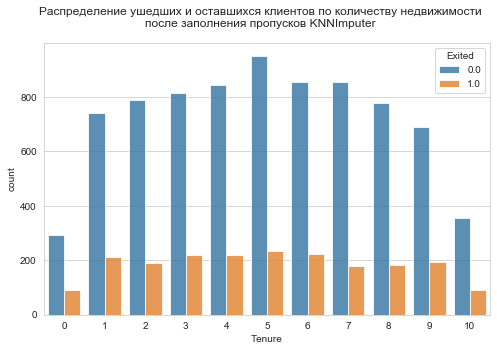

In [57]:
plt.figure(figsize=(8,5))
plt.suptitle("""Распределение ушедших и оставшихся клиентов по количеству недвижимости
после заполнения пропусков KNNImputer""")
sns.countplot(x='Tenure', data=df_knn, hue='Exited', alpha=0.8)
plt.show()

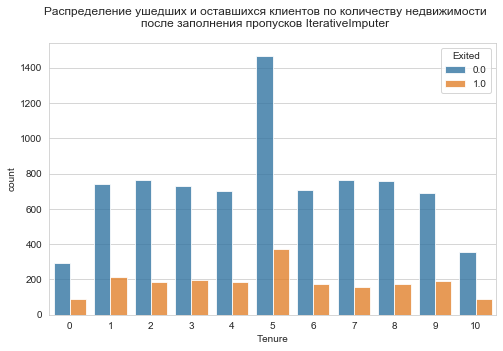

In [58]:
plt.figure(figsize=(8,5))
plt.suptitle("""Распределение ушедших и оставшихся клиентов по количеству недвижимости
после заполнения пропусков IterativeImputer""")
sns.countplot(x='Tenure', data=df_iter, hue='Exited', alpha=0.8)
plt.show()

### Заполнение пропусков

Заполнение при помощи IterativeImputer похоже на заполнение средним. Заполнение методом KNN тоже тяготеет к увеличению числа клиентов с Tenure=5, но в меньшей степени. На данном этапе выберу заполнение <code>KNNImputer</code>.

Чтобы избежать утечки информации в тестовый и валидационный датасет, обучать imputer буду на train.

In [59]:
knn_imputer.fit(X_train)
X_train = pd.DataFrame(data=knn_imputer.transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(data=knn_imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(data=knn_imputer.transform(X_test), columns=X_train.columns)
X_train['Tenure'] = X_train['Tenure'].round(0).astype(int)
X_val['Tenure'] = X_val['Tenure'].round(0).astype(int)
X_test['Tenure'] = X_test['Tenure'].round(0).astype(int)

In [60]:
X_train.isna()['Tenure'].sum(), X_val.isna()['Tenure'].sum(), X_test.isna()['Tenure'].sum()

(0, 0, 0)

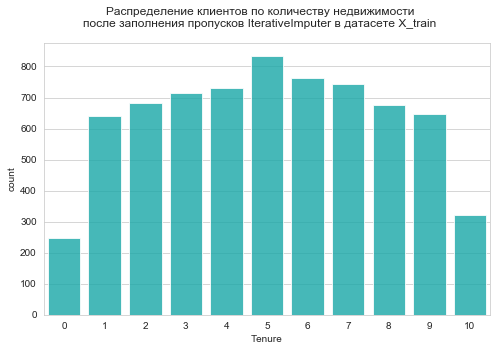

In [61]:
plt.figure(figsize=(8,5))
plt.suptitle("""Распределение клиентов по количеству недвижимости
после заполнения пропусков IterativeImputer в датасете X_train""")
sns.countplot(x='Tenure', data=X_train, alpha=0.8, color='c')
plt.show()

<h2 style="color:DodgerBlue">3.4 Масштабирование признаков</h2>

Приведу количественные признаки к одному масштабу, чтобы задача оптимизации сошлась к хорошему минимуму в регрессионной модели. Использую *стандартизацию* и <code>StandardScaler</code>

In [62]:
to_standard_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler().fit(X_train[to_standard_list])
X_train[to_standard_list] = pd.DataFrame(data=scaler.transform(X_train[to_standard_list]), columns=to_standard_list)
X_val[to_standard_list] = pd.DataFrame(data=scaler.transform(X_val[to_standard_list]), columns=to_standard_list)
X_test[to_standard_list] = pd.DataFrame(data=scaler.transform(X_test[to_standard_list]), columns=to_standard_list)

In [63]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsZeroBalance,Geography_Germany,Geography_Spain,Gender_Male
0,0.314293,0.113190,-0.383330,-1.234380,0.814772,1.0,1.0,0.703619,1.0,0.0,0.0,1.0
1,-0.078915,-0.750021,-0.024311,-1.234380,0.814772,1.0,1.0,-1.016292,1.0,0.0,0.0,1.0
2,0.086646,-0.558196,-1.101368,0.058076,-0.910917,0.0,0.0,0.871941,0.0,0.0,1.0,1.0
3,-0.616989,0.592752,1.052746,0.126026,-0.910917,0.0,1.0,-0.575470,0.0,0.0,1.0,1.0
4,-0.834288,-1.613232,-0.742349,0.502292,-0.910917,0.0,1.0,-0.817005,0.0,0.0,1.0,0.0


Поскольку в процессе преобразований индексы у выборок признаков X сбросились, сброшу индексы и у целевых признаков. 

In [64]:
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

<h2 style="color:DodgerBlue">3.5 Балансировка классов</h2>

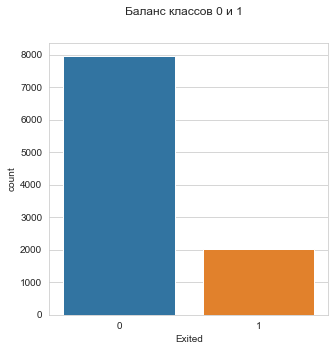

In [65]:
plt.figure(figsize=(5,5))
plt.suptitle('Баланс классов 0 и 1')
sns.countplot(x='Exited', data=df)
plt.show()

In [66]:
print('Отношение числа ушедших клиентов к числу оставшихся:',
( df[df['Exited']==1]['Exited'].count() / df[df['Exited']==0]['Exited'].count() ).round(2) )

Отношение числа ушедших клиентов к числу оставшихся: 0.26


Очевиден дисбаланс классов. Объектов класса 1 (ушедшие клиенты) почти в 4 раза меньше, чем объектов класса 0 (оставшиеся). При разделении выборки была использована стратификация, поэтому класс 1 попал и в тестовую, и в тренировочную, и в валидационную часть.

Важно выявить клиентов, которые собираются покинуть банк. Поэтому точное и полное выявление класса 1 в поставленной задаче очень важно. Полнота, возможно, даже важнее. Лучше выделить тех, кто не собирается уходить, чем пропустить тех, кто уходит.

Сделаю 2 варианта балансировки: upsampling и downsampling. При обучении моделей также укажу class_weight = 'balanced'. Для сравнения сначала обучу модели без балансировки и взвешивания.

### Upsampling и downsampling

In [67]:
X_train_up, y_train_up = upsample(X_train, y_train, 4)
X_train.shape, X_train_up.shape, y_train_up.shape

((7000, 12), (11278, 12), (11278,))

In [68]:
X_train_down, y_train_down = downsample(X_train, y_train, 0.26)
X_train.shape, X_train_down.shape, y_train_down.shape

((7000, 12), (2875, 12), (2875,))

<h1 style="color:SteelBlue">В рамках подготовки данных:</h1>

- категориальные признаки Gender и Geography закодированы прямым кодированием OHE (кодировщик с одним активным состоянием), для исключения мультиколлинеарности использован параметр <code>drop_first = True</code>
- выборка разбита на train-validation-test в пропорции 70%-15%-15%, использована стратификация по целевому признаку
- пропуски заполнены методами <code>KNNImputer</code> и <code>IterativeImputer</code>. Выполнено сравнение результатов, выбран метод <code>KNNImputer</code>
- выполнена стандартизация количественных признаков
- выполнен upsampling и downsampling, подготовлены тренировочные наборы <code>X_train_up, y_train_up, X_train_down, y_train_down</code>

<h1 style="color:SteelBlue"> 4. Обучение моделей</h1>

<h2 style="color:DodgerBlue">4.1 Обучение модели без учёта дисбаланса классов</h2>

Для оценки, вносит ли улучшения учёт дисбаланса классов, обучу модель логистической регрессии без учёта дисбалланса.

In [69]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_val_predict = logreg.predict(X_val)
y_val_predict_proba = logreg.predict_proba(X_val)[:,1]
rand_predict = [random.choice([0, 1]) for i in range (0, len(y_val))]
const_predict = [0 for i in range (0, len(y_val))]

In [70]:
print(f'{"logistic regression":-^60}\n\n', classification_report(y_val, y_val_predict))
print('ROC_AUC:', round(roc_auc_score(y_val, y_val_predict_proba),2))
print(f'{"random model":-^60}\n\n', classification_report(y_val, rand_predict))
print(f'{"constant model":-^60}\n\n', classification_report(y_val, const_predict))

--------------------logistic regression---------------------

               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1194
           1       0.56      0.21      0.30       306

    accuracy                           0.81      1500
   macro avg       0.69      0.58      0.60      1500
weighted avg       0.77      0.81      0.77      1500

ROC_AUC: 0.76
------------------------random model------------------------

               precision    recall  f1-score   support

           0       0.79      0.49      0.60      1194
           1       0.19      0.48      0.28       306

    accuracy                           0.49      1500
   macro avg       0.49      0.48      0.44      1500
weighted avg       0.67      0.49      0.54      1500

-----------------------constant model-----------------------

               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1194
           1       0.00      0.00 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Модель по f1-мере и accuracy превосходит случайную и константную, но класс 1 определяется с плохой полнотой и точностью. И это ожидаемо, т.к. у модели недостаточно данных для его идентификации. 

Теперь обучу, выполнив взвешивание классов, а также - upsampling и downsampling:

In [71]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
y_val_predict = logreg.predict(X_val)
y_val_predict_proba = logreg.predict_proba(X_val)[:,1]
print(f'{"logistic regression, class_weight=balanced":-^60}\n\n', classification_report(y_val, y_val_predict))
print('ROC_AUC:', round(roc_auc_score(y_val, y_val_predict_proba),2))

---------logistic regression, class_weight=balanced---------

               precision    recall  f1-score   support

           0       0.91      0.71      0.79      1194
           1       0.38      0.71      0.50       306

    accuracy                           0.71      1500
   macro avg       0.65      0.71      0.65      1500
weighted avg       0.80      0.71      0.73      1500

ROC_AUC: 0.77


In [72]:
logreg = LogisticRegression()
logreg.fit(X_train_up, y_train_up)
y_val_predict = logreg.predict(X_val)
print(f'{"logistic regression, upsampling":-^60}\n\n', classification_report(y_val, y_val_predict))
y_val_predict_proba = logreg.predict_proba(X_val)[:,1]
print('ROC_AUC:', round(roc_auc_score(y_val, y_val_predict_proba),2))

--------------logistic regression, upsampling---------------

               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1194
           1       0.38      0.73      0.50       306

    accuracy                           0.71      1500
   macro avg       0.65      0.71      0.65      1500
weighted avg       0.80      0.71      0.73      1500

ROC_AUC: 0.77


In [73]:
logreg = LogisticRegression()
logreg.fit(X_train_down, y_train_down)
y_val_predict = logreg.predict(X_val)
print(f'{"logistic regression, downsampling":-^60}\n\n', classification_report(y_val, y_val_predict))
y_val_predict_proba = logreg.predict_proba(X_val)[:,1]
print('ROC_AUC:', round(roc_auc_score(y_val, y_val_predict_proba),2))

-------------logistic regression, downsampling--------------

               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1194
           1       0.39      0.71      0.50       306

    accuracy                           0.71      1500
   macro avg       0.65      0.71      0.65      1500
weighted avg       0.80      0.71      0.74      1500

ROC_AUC: 0.77


Результаты для всех методов балансировки классов примерно одинаковые, но лучший с точки зрения recall+f1 - для upsampling. У модели, обученной с учётом дисбаланса классов, снизилась полнота определения класса 0, зато улучшилась ситуация с классом 1 в плане полноты, а вот точность снизилась (что ожидаемо). Но в данной задаче полнота определения класса 1, на мой взгляд, важнее, чем точность, т.к. важно не пропустить уходящего клиента. 

В этом смысле хотелось бы улучшить показатели. Обучу модели решающего дерева и случайного леса, а также - логистическую регрессию, воспользовавшись GridSearchCV для подбора оптимальных гиперпараметров.

<h2 style="color:DodgerBlue">4.2 Обучение моделей с балансировкой классов</h2>

### 4.2.1 Логистическая регрессия

Для логистической регресси в качестве параметров попробую подобрать:
- оптимальный метод регуляризации: l1 (lasso, регуляризация через манхеттоновское расстояние; позволяет убрать неинформативные признаки) или l2(регуляризация Тихонова, ridge regression, штрафует за большие веса)
- С - "силу" регуляризации

In [74]:
param_grid = {'penalty': ['l1', 'l2'],
              'C':[i for i in np.arange(0.1, 1.1, 0.1)]}
gs = GridSearchCV(LogisticRegression(solver='liblinear', 
                                     class_weight='balanced', 
                                     random_state=271828), param_grid=param_grid, scoring='f1')
gs.fit(X_train, y_train)
gs.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [75]:
%%time
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced')
logreg.fit(X_train_up, y_train_up)

Wall time: 15.7 ms


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
y_val_predict = logreg.predict(X_val)
y_val_predict_proba = logreg.predict_proba(X_val)[:,1]

logreg_report = classification_report(y_val, y_val_predict)
logreg_rocauc = roc_auc_score(y_val, y_val_predict_proba)
print(f'{"logistic regression":-^60}\n\n', logreg_report)
print('ROC_AUC:', round(logreg_rocauc, 2))

--------------------logistic regression---------------------

               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1194
           1       0.39      0.73      0.51       306

    accuracy                           0.72      1500
   macro avg       0.65      0.72      0.66      1500
weighted avg       0.81      0.72      0.74      1500

ROC_AUC: 0.77


Лучшего результата для регрессии добиться пока не удаётся. Посмотрю на веса коэффициентов.

In [77]:
data = []
for feature, coef in zip(X.columns.tolist(), logreg.coef_.tolist()[0]):
    data.append([feature, abs(coef)])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'abs importance'])
feature_importances['abs importance'] = feature_importances['abs importance'].round(3)
feature_importances = feature_importances.sort_values(by='abs importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,abs importance
0,IsActiveMember,0.876
1,Age,0.803
2,Geography_Germany,0.726
3,Gender_Male,0.525
4,Balance,0.185
5,CreditScore,0.062
6,NumOfProducts,0.053
7,Geography_Spain,0.050
8,Tenure,0.033
9,EstimatedSalary,0.031


IsActiveMember, Age, Geography_Germany, Gender_Male, Balance  - основные признаки. Похожий результат был получен в ручном анализе данных, но модель мало использует признаки NumOfProducts и CreditScore. Попробую удалить признаки с малыми весами и повторить обучение.

In [78]:
to_drop_list = ['IsZeroBalance', 'HasCrCard', 'EstimatedSalary', 'Tenure',
                'Geography_Spain']

X_train_up_cleaned = X_train_up.drop(columns=to_drop_list)
X_train_cleaned = X_train.drop(columns=to_drop_list)
X_val_cleaned = X_val.drop(columns=to_drop_list)

In [79]:
gs = GridSearchCV(LogisticRegression(solver='liblinear', 
                                     class_weight='balanced', 
                                     random_state=271828), param_grid=param_grid, scoring='f1')
gs.fit(X_train_cleaned, y_train)
gs.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [80]:
logreg2 = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced')
logreg2.fit(X_train_up_cleaned, y_train_up)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
data = []
for feature, coef in zip(X_train_up_cleaned.columns.tolist(), logreg2.coef_.tolist()[0]):
    data.append([feature, abs(coef)])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'abs importance'])
feature_importances['abs importance'] = feature_importances['abs importance'].round(3)
feature_importances = feature_importances.sort_values(by='abs importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,abs importance
0,IsActiveMember,0.875
1,Age,0.803
2,Geography_Germany,0.708
3,Gender_Male,0.526
4,Balance,0.185
5,CreditScore,0.062
6,NumOfProducts,0.052


In [82]:
y_val_predict = logreg2.predict(X_val_cleaned)
y_val_predict_proba = logreg2.predict_proba(X_val_cleaned)[:,1]
logreg2_report = classification_report(y_val, y_val_predict)
logreg2_rocauc = roc_auc_score(y_val, y_val_predict_proba)

print(f'{"logistic regression, cleaned X":-^60}\n\n', logreg2_report)
print('ROC_AUC:', round(logreg2_rocauc,2))

---------------logistic regression, cleaned X---------------

               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1194
           1       0.39      0.72      0.50       306

    accuracy                           0.71      1500
   macro avg       0.65      0.71      0.65      1500
weighted avg       0.80      0.71      0.74      1500

ROC_AUC: 0.77


Если варьировать порог вероятности, можно повысить точность за счёт снижения полноты. Лучшее значение f1 достигается при пороге 0.6. Однако результат всё равно неудовлетворительный:

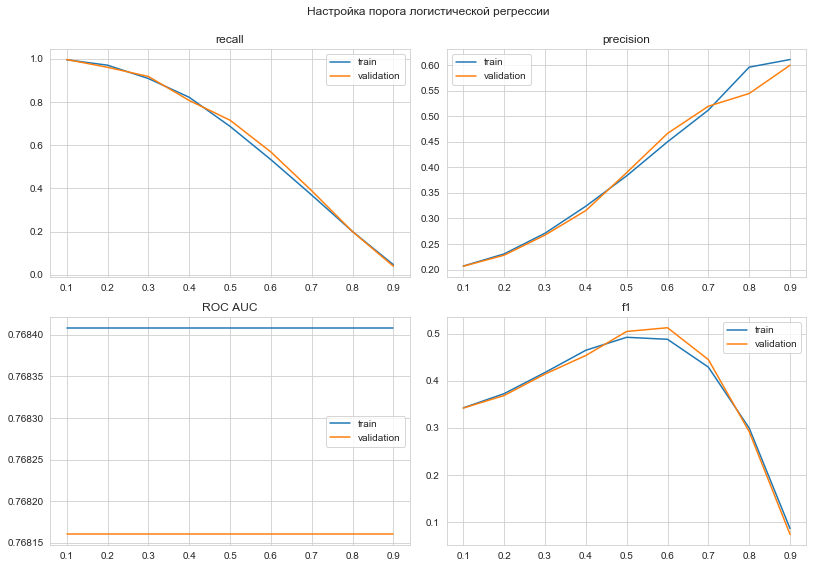

In [83]:
recall_valid = []
precision_valid = []
f1_valid = []
roc_auc_valid = []

recall_train = []
precision_train = []
f1_train = []
roc_auc_train = []

for i in np.arange(0.1, 1, 0.1):
        
        y_val_predict_proba = logreg2.predict_proba(X_val_cleaned)[:,1]
        y_train_predict_proba = logreg2.predict_proba(X_train_cleaned)[:,1]
        y_val_predicted = y_val_predict_proba > i
        y_train_predicted = y_train_predict_proba > i

        recall_valid.append(recall_score(y_val, y_val_predicted))
        precision_valid.append(precision_score(y_val, y_val_predicted))
        f1_valid.append(f1_score(y_val, y_val_predicted))
        roc_auc_valid.append(roc_auc_score(y_val, y_val_predict_proba))

        recall_train.append(recall_score(y_train, y_train_predicted))
        precision_train.append(precision_score(y_train, y_train_predicted))
        f1_train.append(f1_score(y_train, y_train_predicted))
        roc_auc_train.append(roc_auc_score(y_train, y_train_predict_proba))
        
plt.figure(figsize=(12,8))
x = [i for i in np.arange(0.1, 1, 0.1)]
plt.subplot(221)
plt.plot(x, recall_train, label='train')
plt.plot(x, recall_valid, label='validation')
plt.title('recall')
plt.legend()
plt.xticks(x)

plt.subplot(222)
plt.plot(x, precision_train, label='train')
plt.plot(x, precision_valid, label='validation')
plt.title('precision')
plt.legend()
plt.xticks(x)

plt.subplot(223)
plt.plot(x, roc_auc_train, label='train')
plt.plot(x, roc_auc_valid, label='validation')
plt.title('ROC AUC')
plt.legend()
plt.xticks(x)

plt.subplot(224)
plt.plot(x, f1_train, label='train')
plt.plot(x, f1_valid, label='validation')
plt.title('f1')
plt.legend()
plt.xticks(x)

plt.suptitle('Настройка порога логистической регрессии')
plt.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

In [84]:
y_val_predict_proba = logreg2.predict_proba(X_val_cleaned)[:,1]
y_val_predict = y_val_predict_proba >= 0.6
print(f'{"logistic regression, cleaned X, treshold=0.6":-^60}\n\n', classification_report(y_val, y_val_predict))
print('ROC_AUC:', round(roc_auc_score(y_val, y_val_predict_proba),2))

--------logistic regression, cleaned X, treshold=0.6--------

               precision    recall  f1-score   support

           0       0.88      0.83      0.86      1194
           1       0.47      0.57      0.51       306

    accuracy                           0.78      1500
   macro avg       0.67      0.70      0.68      1500
weighted avg       0.80      0.78      0.79      1500

ROC_AUC: 0.77


С логистической регрессией лучшего результата не получается. Перейду к решающему дереву.

### 4.2.2 Решающее дерево

Для поиска оптимальной глубины решающего дерева воспользуюсь <code>recall_score, precision_score, f1_score, ROC_AUC</code> и matplotlib для визуализации результатов. GridSearchCV не даёт понимания о характере изменений при изменении гиперпараметров, его использую как второй метод.

In [85]:
#функция построения графиков для метрик в зависимости от глубины дерева
def tree_estimation(X_train, X_train_up, X_val, y_train, y_train_up, y_val,
                     suptitle='Решающее дерево\nпоиск оптимальной глубины', 
                     start_depth=1, max_depth = 30, depth_step = 1):
    
    
    max_depth = max_depth + depth_step
    
    recall_valid = []
    precision_valid = []
    f1_valid = []
    roc_auc_valid = []

    recall_train = []
    precision_train = []
    f1_train = []
    roc_auc_train = []
    
    for depth in range(start_depth, max_depth, depth_step):
        model = DecisionTreeClassifier(class_weight='balanced', 
                                           random_state=271828,      
                                           max_depth=depth)
        model.fit(X_train_up, y_train_up)
        y_val_predicted = model.predict(X_val)
        y_train_predicted = model.predict(X_train)

        y_val_predict_proba = model.predict_proba(X_val)[:,1]
        y_train_predict_proba = model.predict_proba(X_train)[:,1]

        recall_valid.append(recall_score(y_val, y_val_predicted))
        precision_valid.append(precision_score(y_val, y_val_predicted))
        f1_valid.append(f1_score(y_val, y_val_predicted))
        roc_auc_valid.append(roc_auc_score(y_val, y_val_predict_proba))

        recall_train.append(recall_score(y_train, y_train_predicted))
        precision_train.append(precision_score(y_train, y_train_predicted))
        f1_train.append(f1_score(y_train, y_train_predicted))
        roc_auc_train.append(roc_auc_score(y_train, y_train_predict_proba))
        
    plt.figure(figsize=(12,8))
    x = [i for i in range(start_depth, max_depth, depth_step)]
    plt.subplot(221)
    plt.plot(x, recall_train, label='train')
    plt.plot(x, recall_valid, label='validation')
    plt.title('recall')
    plt.legend()
    plt.xticks(x)

    plt.subplot(222)
    plt.plot(x, precision_train, label='train')
    plt.plot(x, precision_valid, label='validation')
    plt.title('precision')
    plt.legend()
    plt.xticks(x)

    plt.subplot(223)
    plt.plot(x, roc_auc_train, label='train')
    plt.plot(x, roc_auc_valid, label='validation')
    plt.title('ROC AUC')
    plt.legend()
    plt.xticks(x)

    plt.subplot(224)
    plt.plot(x, f1_train, label='train')
    plt.plot(x, f1_valid, label='validation')
    plt.title('f1')
    plt.legend()
    plt.xticks(x)

    plt.suptitle(suptitle)
    plt.tight_layout(rect=(0,0,0.95,0.95))
    plt.show()

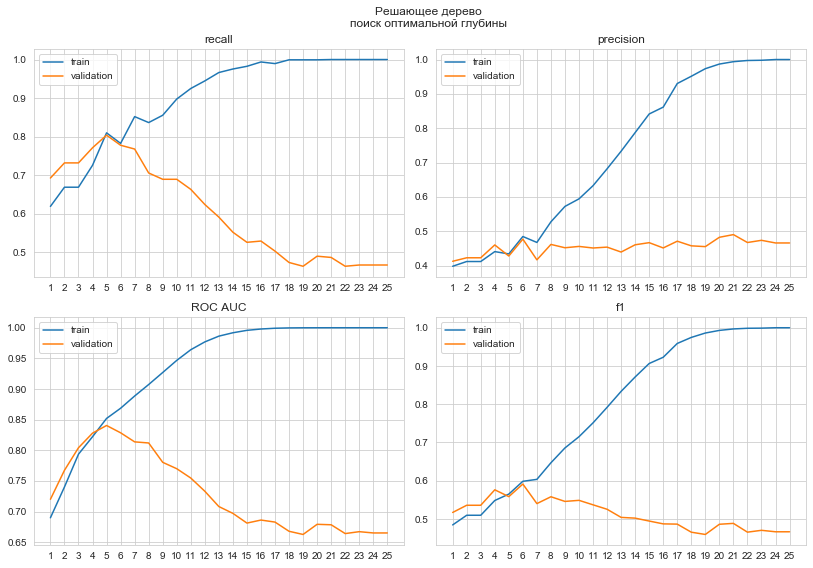

In [86]:
tree_estimation(X_train, X_train_up, X_val, y_train, y_train_up, y_val,
                     suptitle='Решающее дерево\nпоиск оптимальной глубины', 
                     start_depth=1, max_depth = 25, depth_step = 1)

Лучшая глубина решающего дерева - <code>max_depth 4 - 6</code>. Выберу **6**, у которого максимум f1, хороший recall и precision.

А вот результат GridSearchCV (без upsampling, т.к. на upsampling результат получается неверный, дерево переучивается):

In [87]:
gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=271828),
                  param_grid={'max_depth':[i for i in range(1,31)]}, scoring='f1')
gs.fit(X_train, y_train)
print('scoring=f1, GridSearchCV best parameters:', gs.best_params_)

scoring=f1, GridSearchCV best parameters: {'max_depth': 6}


In [88]:
gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=271828),
                  param_grid={'max_depth':[i for i in range(1,31)]}, scoring='recall')
gs.fit(X_train, y_train)
print('scoring=recall, GridSearchCV best parameters:', gs.best_params_)

scoring=recall, GridSearchCV best parameters: {'max_depth': 4}


Результат аналогичный. Обучу дерево на <code>max_depth=6</code>

In [89]:
tree = DecisionTreeClassifier(class_weight='balanced', random_state=271828, max_depth=6)
tree.fit(X_train_up, y_train_up)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=271828, splitter='best')

In [90]:
y_val_predict = tree.predict(X_val)
y_val_predict_proba = tree.predict_proba(X_val)[:,1]
tree_report = classification_report(y_val, y_val_predict)
tree_rocauc = roc_auc_score(y_val, y_val_predict_proba)

print(f'{"Decision tree":-^60}\n\n', tree_report)
print('ROC_AUC:', round(tree_rocauc,2))

-----------------------Decision tree------------------------

               precision    recall  f1-score   support

           0       0.93      0.78      0.85      1194
           1       0.48      0.78      0.59       306

    accuracy                           0.78      1500
   macro avg       0.70      0.78      0.72      1500
weighted avg       0.84      0.78      0.80      1500

ROC_AUC: 0.83


Посмотрю на значимость признаков и попробую оптимизировать число признаков.

In [91]:
data = []
for feature, coef in zip(X.columns.tolist(), tree.feature_importances_.tolist()):
    data.append([feature, coef])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'importance'])
feature_importances['importance'] = feature_importances['importance'].round(3)
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,Age,0.418
1,NumOfProducts,0.311
2,Balance,0.112
3,IsActiveMember,0.081
4,Geography_Germany,0.036
5,EstimatedSalary,0.014
6,Gender_Male,0.012
7,IsZeroBalance,0.008
8,Tenure,0.006
9,CreditScore,0.000


<code>'Geography_Spain','HasCrCard', 'CreditScore'</code> вообще не используются. Попробую исключить малозначимые признаки и переобучить дерево решений.

In [92]:
to_drop_list = ['Geography_Spain','HasCrCard', 'CreditScore', 'Tenure', 
                'IsZeroBalance', 'Gender_Male', 'EstimatedSalary']
X_train_up_cleaned = X_train_up.drop(columns=to_drop_list)
X_val_cleaned = X_val.drop(columns=to_drop_list)
X_train_cleaned = X_train.drop(columns=to_drop_list)

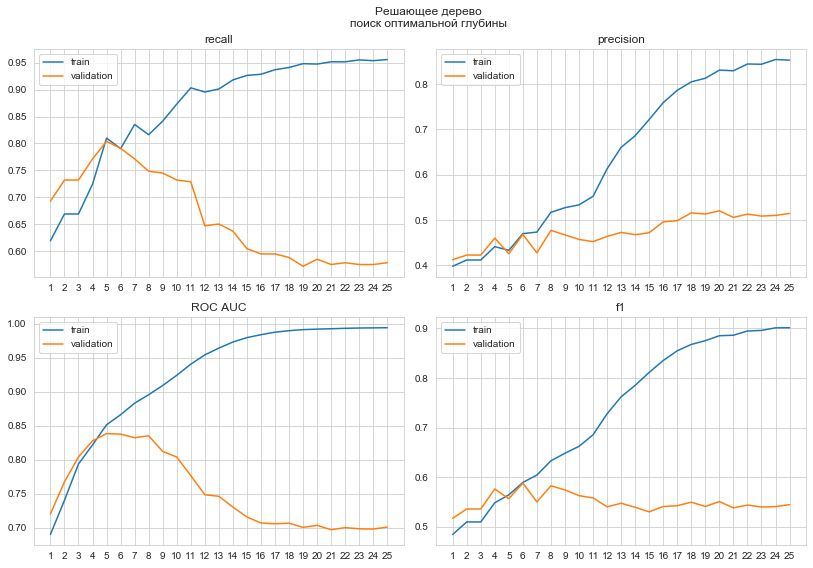

In [93]:
tree_estimation(X_train_cleaned, X_train_up_cleaned, X_val_cleaned, y_train, y_train_up, y_val,
                suptitle='Решающее дерево\nпоиск оптимальной глубины', 
                start_depth=1, max_depth = 25, depth_step = 1)

Теперь за счёт увеличения глубины дерева можно добиться роста точности. Но сохранившееся падение полноты сводит данный успех на нет. **Глубина 6 по прежнему даёт лучший результат**. Видно, что дерево стало меньше переобучаться. GridSearchCV подтверждает результат

In [94]:
gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=271828),
                  param_grid={'max_depth':[i for i in range(1,31)]}, scoring='f1')
gs.fit(X_train_cleaned, y_train)
print('scoring=f1, GridSearchCV best parameters:', gs.best_params_)

scoring=f1, GridSearchCV best parameters: {'max_depth': 7}


In [95]:
gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=271828),
                  param_grid={'max_depth':[i for i in range(1,31)]}, scoring='recall')
gs.fit(X_train_cleaned, y_train)
print('scoring=recall, GridSearchCV best parameters:', gs.best_params_)

scoring=recall, GridSearchCV best parameters: {'max_depth': 6}


In [96]:
tree2 = DecisionTreeClassifier(class_weight='balanced', random_state=271828, max_depth=6)
tree2.fit(X_train_up_cleaned, y_train_up)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=271828, splitter='best')

In [97]:
data = []
for feature, coef in zip(X_train_up_cleaned.columns.tolist(), tree2.feature_importances_.tolist()):
    data.append([feature, coef])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'importance'])
feature_importances['importance'] = feature_importances['importance'].round(3)
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,Age,0.429
1,NumOfProducts,0.315
2,Balance,0.128
3,IsActiveMember,0.088
4,Geography_Germany,0.040


In [98]:
y_val_predict = tree2.predict(X_val_cleaned)
y_val_predict_proba = tree2.predict_proba(X_val_cleaned)[:,1]
tree2_report = classification_report(y_val, y_val_predict)
tree2_rocauc = roc_auc_score(y_val, y_val_predict_proba)

print( f'{"Decision tree, X cleaned":-^60}\n\n', tree2_report )
print( 'ROC_AUC:', round(tree2_rocauc,2) )

------------------Decision tree, X cleaned------------------

               precision    recall  f1-score   support

           0       0.93      0.77      0.84      1194
           1       0.47      0.79      0.59       306

    accuracy                           0.77      1500
   macro avg       0.70      0.78      0.72      1500
weighted avg       0.84      0.77      0.79      1500

ROC_AUC: 0.84


Стало чуть лучше. Перейду к случайному лесу.

### 4.2.3 Случайный лес

Для поиска оптимальной глубины и количества деревьев решающего леса воспользуюсь. так же как для решающего дерева, <code>recall_score, precision_score, f1_score, ROC_AUC</code> и matplotlib для визуализации результатов. GridSearchCV не даёт понимания о характере изменений при изменении гиперпараметров, его использую как второй метод.

In [99]:
#функция построения графиков для метрик в зависимости от глубины дерева и числа деревьев
def forest_estimation(X_train, X_train_up, X_val, y_train, y_train_up, y_val,
                     start_depth=6, max_depth=16, depth_step=2,
                     start_est=10, max_est=100, est_step=10):
    
    
    max_depth = max_depth + depth_step
    max_est = max_est + est_step
       
    for depth in range(start_depth, max_depth, depth_step):
        
        recall_valid = []
        precision_valid = []
        f1_valid = []
        roc_auc_valid = []

        recall_train = []
        precision_train = []
        f1_train = []
        roc_auc_train = []
        
        for n_estimators in range(start_est, max_est, est_step):
        
            model = RandomForestClassifier(class_weight='balanced', random_state=271828,
                                           max_depth=depth, n_estimators=n_estimators)
            
            model.fit(X_train_up, y_train_up)
            y_val_predicted = model.predict(X_val)
            y_train_predicted = model.predict(X_train)

            y_val_predict_proba = model.predict_proba(X_val)[:,1]
            y_train_predict_proba = model.predict_proba(X_train)[:,1]

            recall_valid.append(recall_score(y_val, y_val_predicted))
            precision_valid.append(precision_score(y_val, y_val_predicted))
            f1_valid.append(f1_score(y_val, y_val_predicted))
            roc_auc_valid.append(roc_auc_score(y_val, y_val_predict_proba))

            recall_train.append(recall_score(y_train, y_train_predicted))
            precision_train.append(precision_score(y_train, y_train_predicted))
            f1_train.append(f1_score(y_train, y_train_predicted))
            roc_auc_train.append(roc_auc_score(y_train, y_train_predict_proba))
        
        plt.figure(figsize=(12,8))
        x = [i for i in range(start_est, max_est, est_step)]
        plt.subplot(221)
        plt.plot(x, recall_train, label='train')
        plt.plot(x, recall_valid, label='validation')
        plt.title('recall')
        plt.legend()
        plt.xticks(x)

        plt.subplot(222)
        plt.plot(x, precision_train, label='train')
        plt.plot(x, precision_valid, label='validation')
        plt.title('precision')
        plt.legend()
        plt.xticks(x)

        plt.subplot(223)
        plt.plot(x, roc_auc_train, label='train')
        plt.plot(x, roc_auc_valid, label='validation')
        plt.title('ROC AUC')
        plt.legend()
        plt.xticks(x)

        plt.subplot(224)
        plt.plot(x, f1_train, label='train')
        plt.plot(x, f1_valid, label='validation')
        plt.title('f1')
        plt.legend()
        plt.xticks(x)

        plt.suptitle(f'Случайный лес\nпоиск оптимальной глубины и числа деревьев. Depth = {depth} ')
        plt.tight_layout(rect=(0,0,0.95,0.95))
        plt.show()

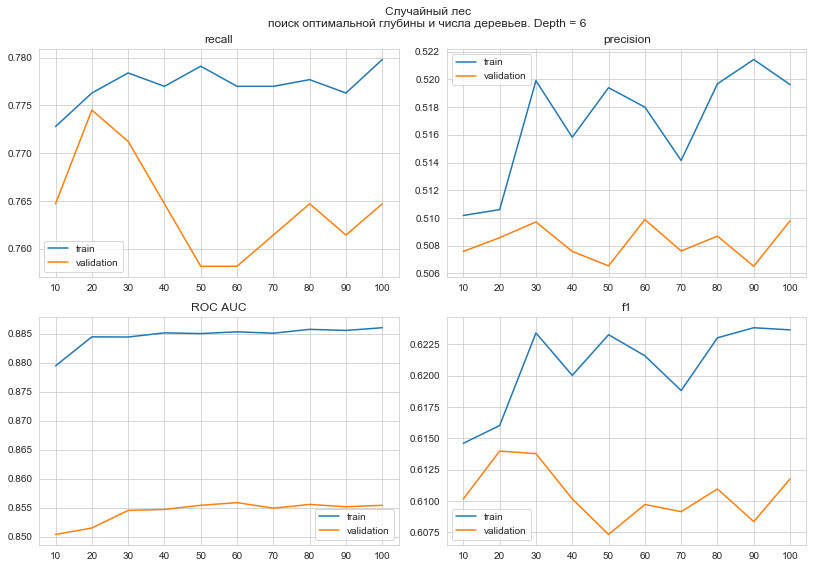

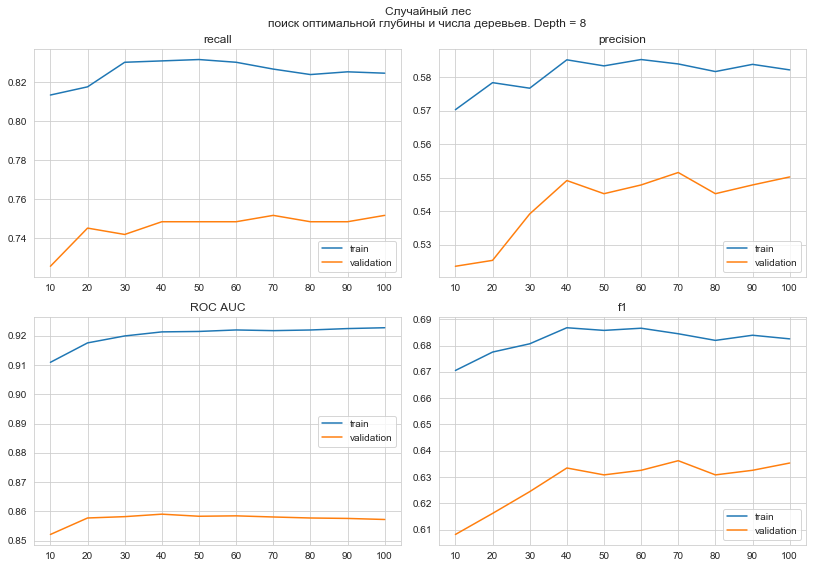

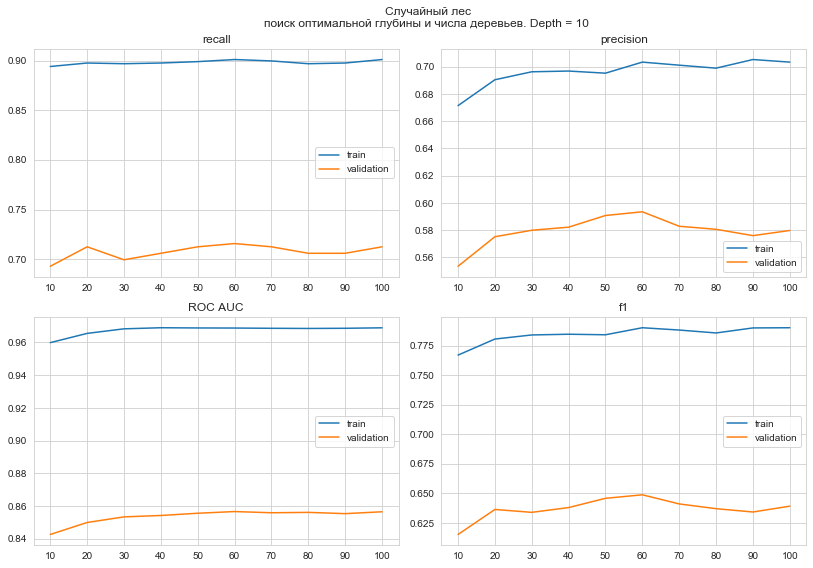

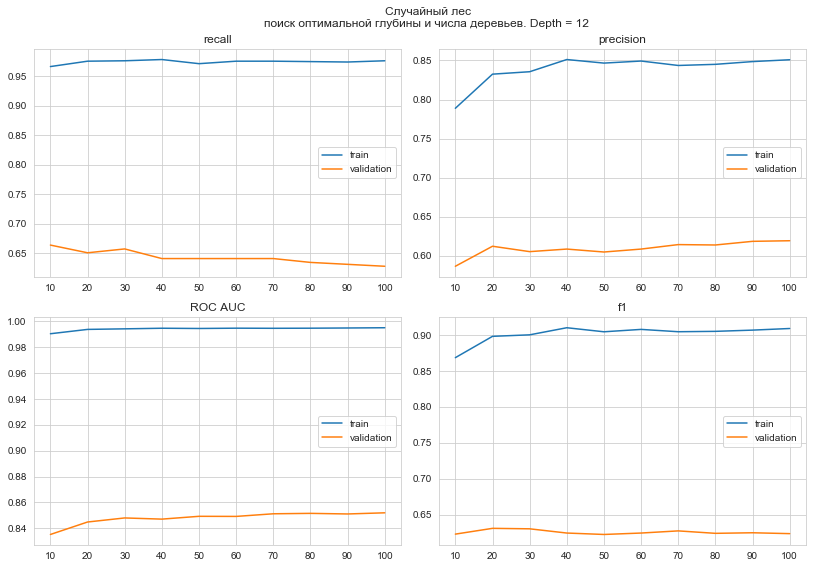

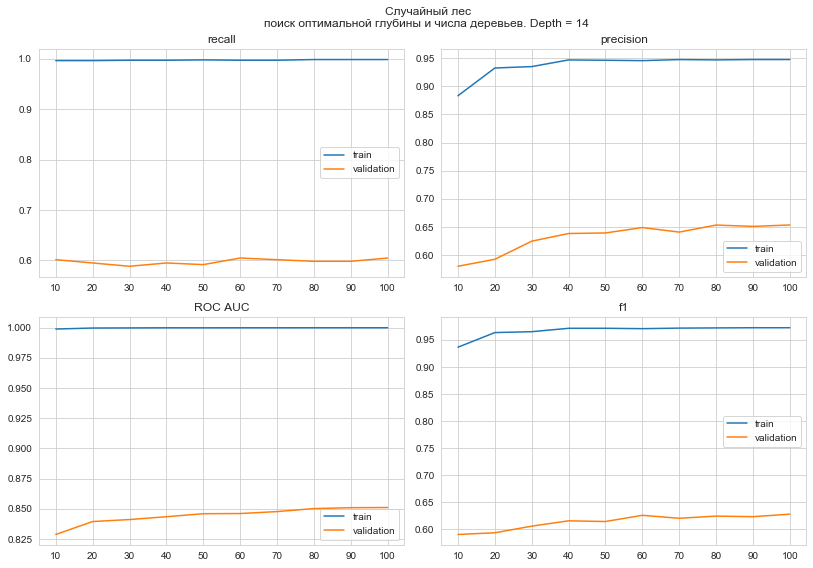

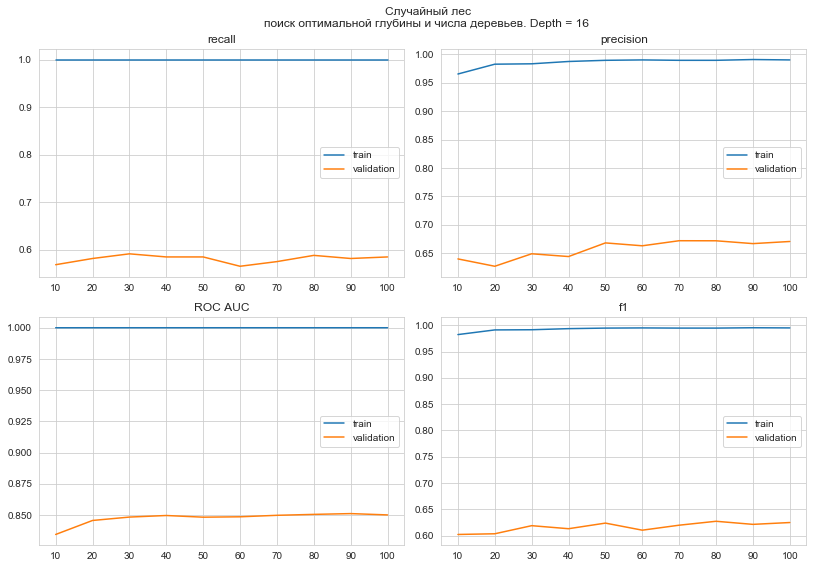

In [100]:
forest_estimation(X_train, X_train_up, X_val, y_train, y_train_up, y_val,
                     start_depth=6, max_depth=16, depth_step=2,
                     start_est=10, max_est=100, est_step=10)

In [101]:
param_grid={'max_depth':[i for i in range(4,22,2)],
            'n_estimators':[i for i in range(10,110,10)]}

gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=271828),
                  param_grid=param_grid, scoring='f1')
gs.fit(X_train, y_train)
print('scoring=f1, GridSearchCV best parameters:', gs.best_params_)

scoring=f1, GridSearchCV best parameters: {'max_depth': 10, 'n_estimators': 100}


Видно, что с ростом глубины деревьев модель стабилизируется. При глубинах 8-10 модель уже достаточно стабильна. С дальнейшим ростом глубины падает recall и растёт точность. На мой взгляд в данной задачи recall важнее precision, т.к. лучше обратить внимание на ложноуходящего клиента, чем пропустить действительно уходящего. Тем более, баланс показателей в виде f1 меры вполне приличный уже на глубинах 8-10.

Выберу <code>Depth = 10 и n_estimators = 60</code>, как, на мой взгляд, наиболее сбалансированный для поставленной задачи вариант. Похожий вариант рекомендует GridSearchCV, но визуально по графикам не вижу смысла делать 100 деревьев.

In [102]:
%%time
forest = RandomForestClassifier(class_weight='balanced',
                                random_state=271828,
                                max_depth=10,
                                n_estimators=60)
forest.fit(X_train_up, y_train_up)

Wall time: 448 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

In [103]:
y_val_predict = forest.predict(X_val)
y_val_predict_proba = forest.predict_proba(X_val)[:,1]

forest_report = classification_report(y_val, y_val_predict)
forest_rocauc = roc_auc_score(y_val, y_val_predict_proba)

print(f'{"RandomForest":-^60}\n\n', forest_report)
print( 'ROC_AUC:', round(forest_rocauc,2) )

------------------------RandomForest------------------------

               precision    recall  f1-score   support

           0       0.92      0.87      0.90      1194
           1       0.59      0.72      0.65       306

    accuracy                           0.84      1500
   macro avg       0.76      0.80      0.77      1500
weighted avg       0.86      0.84      0.85      1500

ROC_AUC: 0.86


In [104]:
data = []
for feature, coef in zip(X.columns.tolist(), forest.feature_importances_.tolist()):
    data.append([feature, coef])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'importance'])
feature_importances['importance'] = feature_importances['importance'].round(3)
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,Age,0.323
1,NumOfProducts,0.214
2,Balance,0.097
3,EstimatedSalary,0.079
4,CreditScore,0.074
5,IsActiveMember,0.057
6,Tenure,0.043
7,Geography_Germany,0.043
8,Gender_Male,0.025
9,IsZeroBalance,0.023


Попробую исключить признаки <code>Geography_Spain, HasCrCard, IsZeroBalance, Gender_Male, Tenure</code>. Проведу ещё раз проверку по сетке.

In [105]:
to_drop_list = ['Geography_Spain','HasCrCard', 'IsZeroBalance', 'Gender_Male', 'Tenure']
X_train_up_cleaned = X_train_up.drop(columns=to_drop_list)
X_val_cleaned = X_val.drop(columns=to_drop_list)
X_train_cleaned = X_train.drop(columns=to_drop_list)

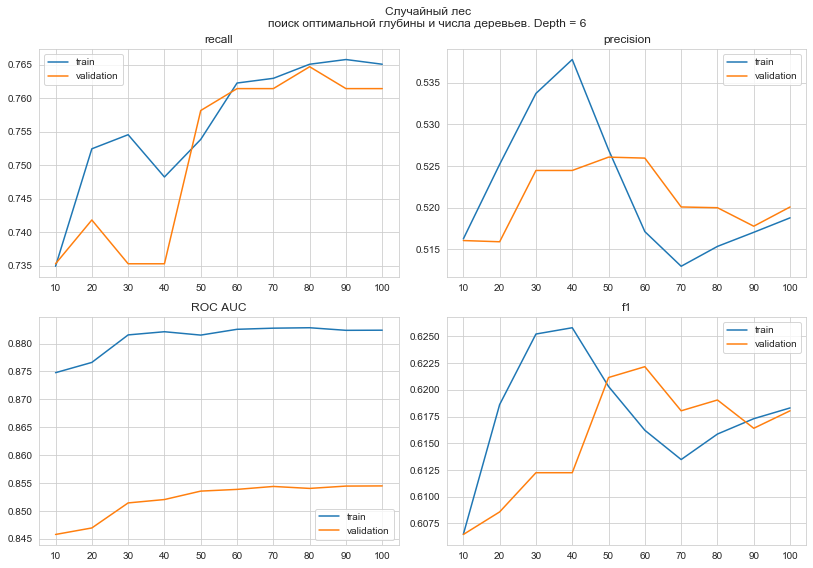

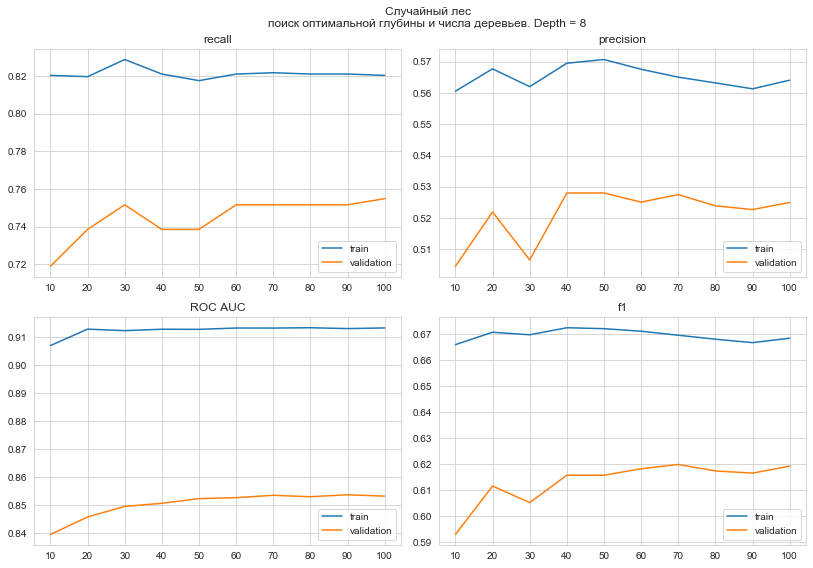

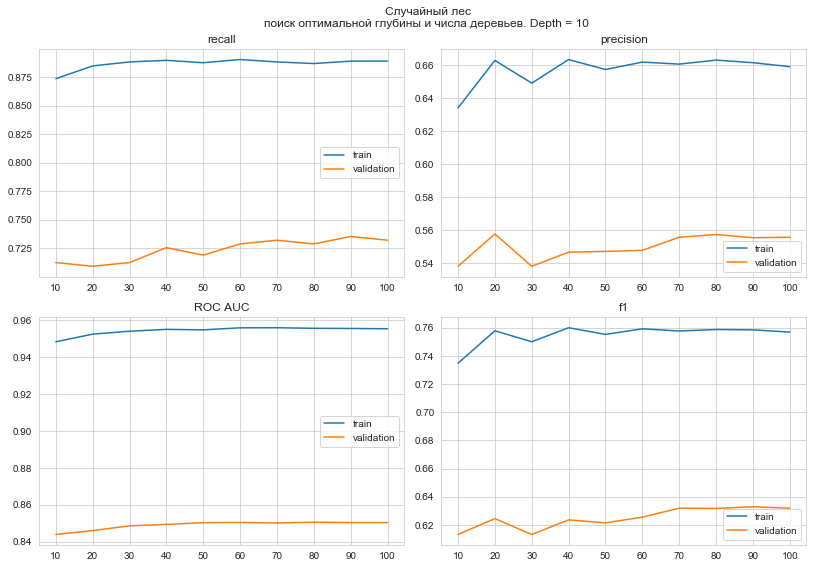

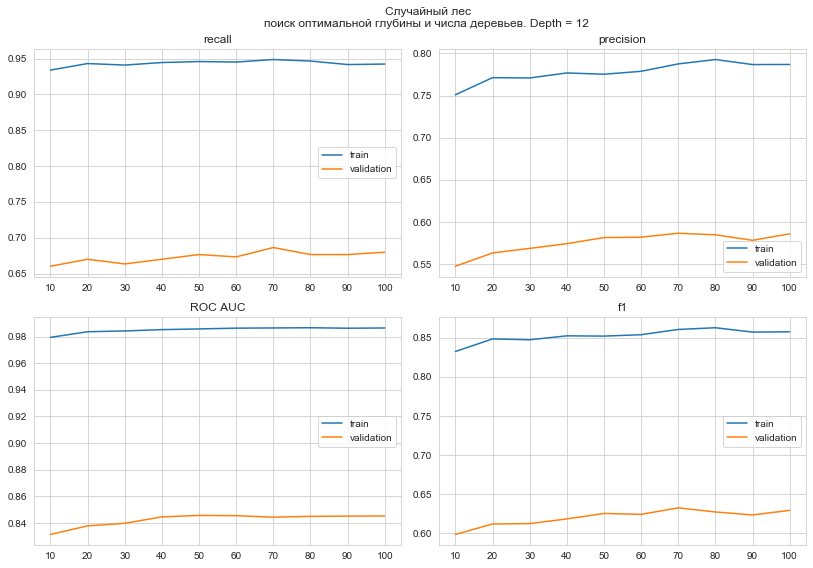

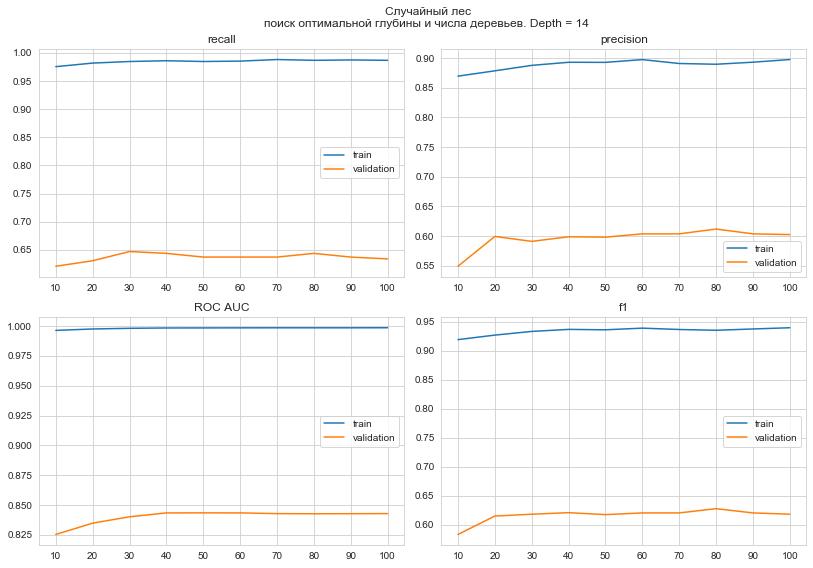

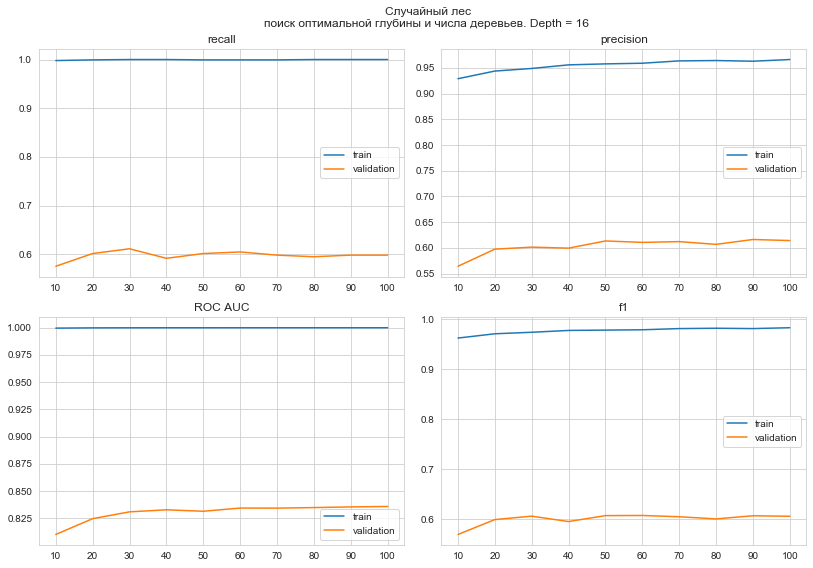

In [106]:
forest_estimation(X_train_cleaned, X_train_up_cleaned, X_val_cleaned, y_train, y_train_up, y_val,
                     start_depth=6, max_depth=16, depth_step=2,
                     start_est=10, max_est=100, est_step=10)

In [107]:
param_grid={'max_depth':[i for i in range(4,22,2)],
            'n_estimators':[i for i in range(10,110,10)]}

gs = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=271828),
                  param_grid=param_grid, scoring='f1')
gs.fit(X_train_cleaned, y_train)
print('scoring=f1, GridSearchCV best parameters:', gs.best_params_)

scoring=f1, GridSearchCV best parameters: {'max_depth': 10, 'n_estimators': 70}


Есть отличия. <code>Depth = 10 и n_estimators = 70</code> выглядит достаточно оптимально.

In [108]:
%%time
forest2 = RandomForestClassifier(class_weight='balanced',
                                random_state=271828,
                                max_depth=10,
                                n_estimators=70)
forest2.fit(X_train_up_cleaned, y_train_up)

Wall time: 533 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

In [109]:
y_val_predict = forest2.predict(X_val_cleaned)
y_val_predict_proba = forest2.predict_proba(X_val_cleaned)[:,1]

forest2_report = classification_report(y_val, y_val_predict)
forest2_rocauc = roc_auc_score(y_val, y_val_predict_proba)

print( f'{"RandomForest 2, X cleaned":-^60}\n\n', forest2_report )
print( 'ROC_AUC:', round(forest2_rocauc,2) )

-----------------RandomForest 2, X cleaned------------------

               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1194
           1       0.56      0.73      0.63       306

    accuracy                           0.83      1500
   macro avg       0.74      0.79      0.76      1500
weighted avg       0.85      0.83      0.83      1500

ROC_AUC: 0.85


Попробую ещё обучить лес на downsampling данных, посмотрю результат.

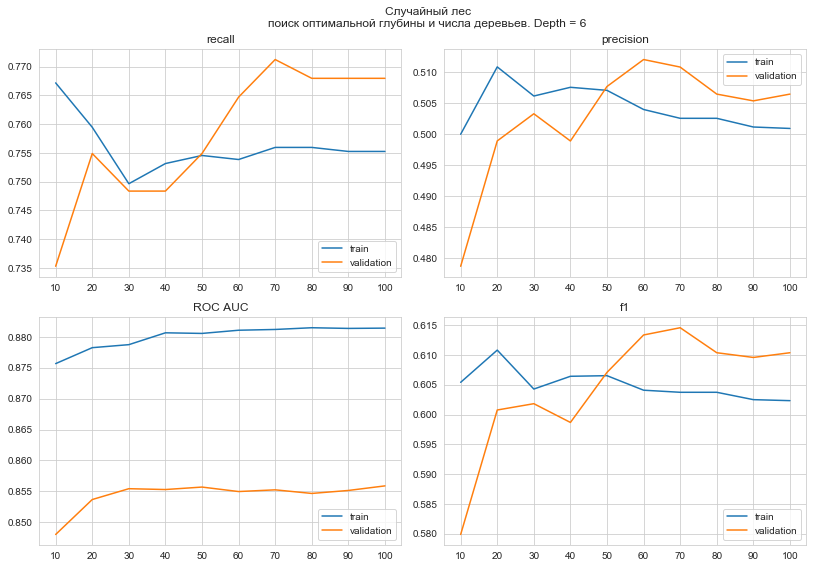

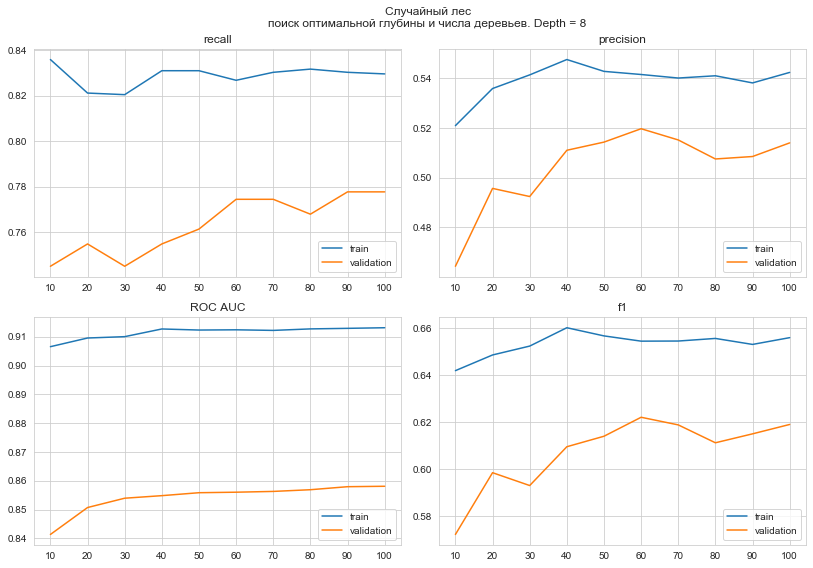

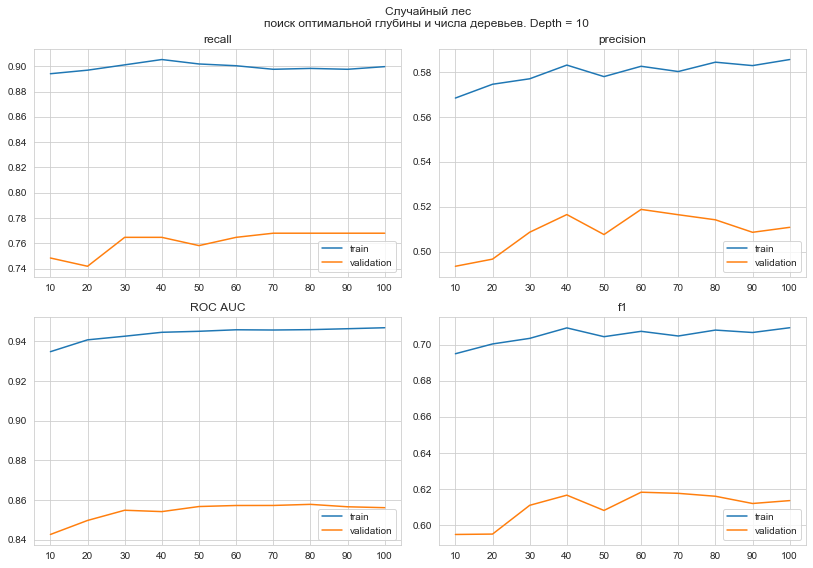

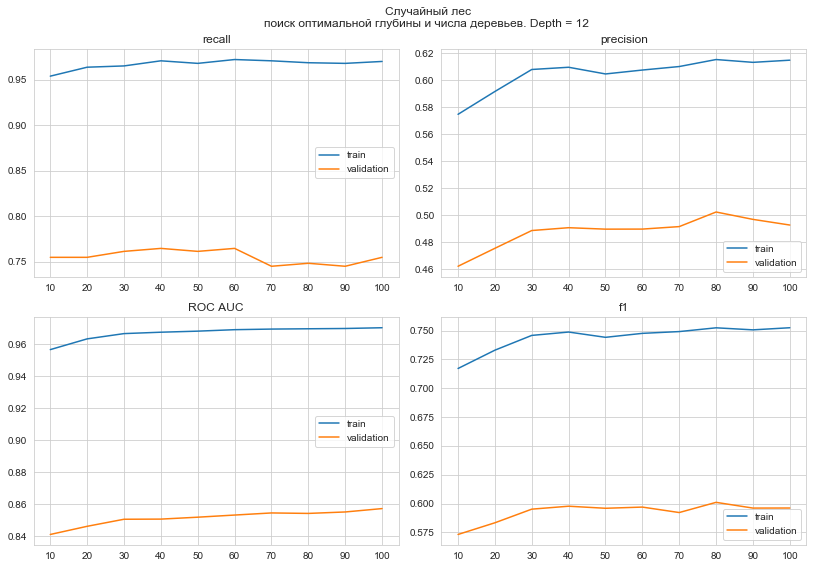

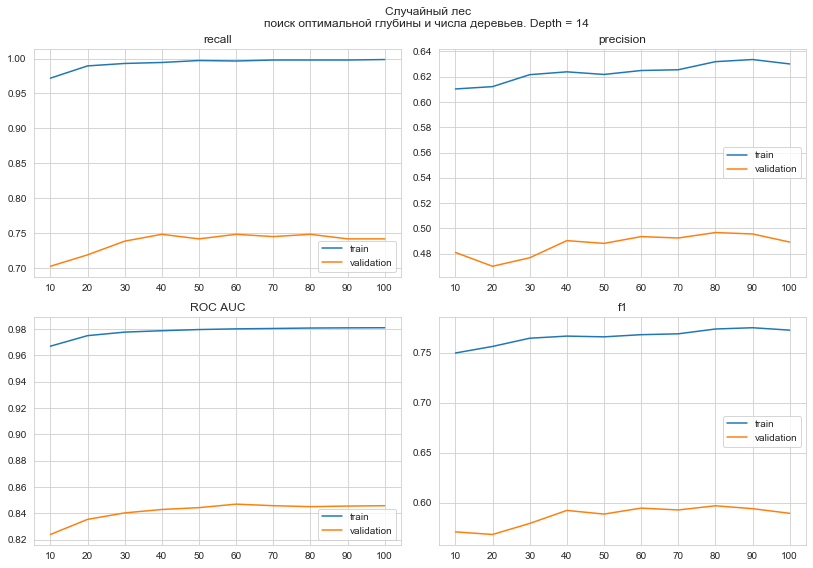

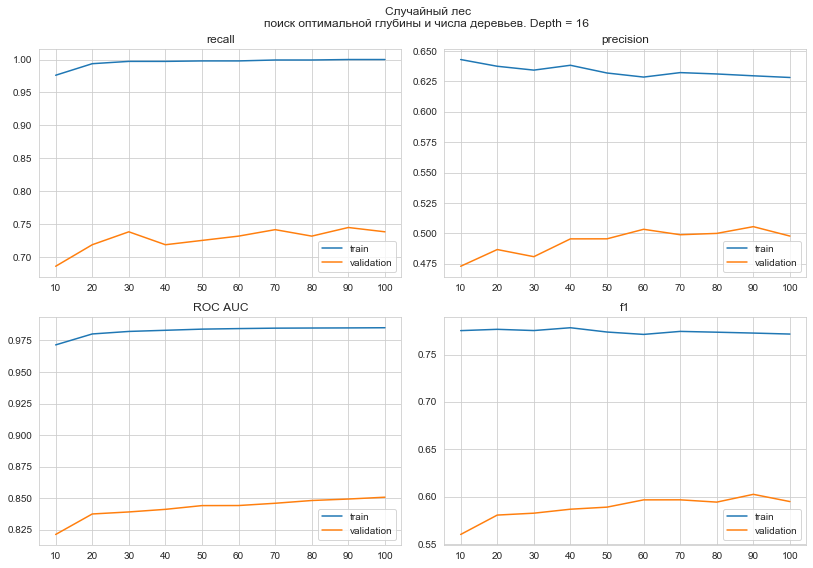

In [110]:
forest_estimation(X_train, X_train_down, X_val, y_train, y_train_down, y_val,
                     start_depth=6, max_depth=16, depth_step=2,
                     start_est=10, max_est=100, est_step=10)

Recall лучше, но точность и f1-мера всё же хуже.

<h1 style="color:SteelBlue">Результаты обучения моделей и подбора гиперпараметров:</h1>

Была поставлена задача классификации с дисбалансом классов. Сделана попытка обучения логистической регрессии без балансировки. Результат значительно хуже, чем при обучении с балансировкой. Лучший результат показала балансировка методом upsampling. С использованием upsampling обучено три модели. Подобраны с помощью GridSearchCV и анализа графиков оптимальные гиперпараметры.

Получены следующие модели:

In [111]:
print(f'\n{"logistic regression":-^60}\n\n', logreg_report)
print('ROC_AUC:', round(logreg_rocauc,2))
print(logreg)

print(f'\n{"logistic regression 2":-^60}\n\n', logreg2_report)
print('ROC_AUC:', round(logreg2_rocauc,2))
print(logreg2)

print(f'\n{"decision tree":-^60}\n\n', tree_report)
print('ROC_AUC:', round(tree_rocauc,2))
print(tree)

print(f'\n{"decision tree 2":-^60}\n\n', tree2_report)
print('ROC_AUC:', round(tree2_rocauc,2))
print(tree2)

print(f'\n{"random forest":-^60}\n\n', forest_report)
print('ROC_AUC:', round(forest_rocauc,2))
print(forest)

print(f'\n{"random forest 2":-^60}\n\n', forest2_report)
print('ROC_AUC:', round(forest2_rocauc,2))
print(forest2)


--------------------logistic regression---------------------

               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1194
           1       0.39      0.73      0.51       306

    accuracy                           0.72      1500
   macro avg       0.65      0.72      0.66      1500
weighted avg       0.81      0.72      0.74      1500

ROC_AUC: 0.77
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

-------------------logistic regression 2--------------------

               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1194
           1       0.39      0.72      0.50       306

    accuracy                   

Разберёмся в значениях precision и recall. Интерес представляет класс 1, поэтому говорить будем про него. 


$$ precision = \frac{TP}{TP+FP} \$$


$$ recall = \frac{TP}{TP+FN} \$$


Т.е.


$$ FP = \frac{TP - TP\cdot precision}{precision} \$$


$$ FN = \frac{TP - TP\cdot recall}{recall} \$$


Посмотрим, что это означает в значениях ложных срабатываний (FP) и пропусков (FN). Посчитаю, сколько ложных срабатываний и пропусков приходится на 100 правильно выбранных уходящих клиентов.

In [112]:
def FP_FN_calc(precision, recall):
    fp = round( (100 - 100*precision)/precision, 0 )
    fn = round( (100 - 100*recall)/recall, 0 )
    return fp, fn

In [113]:
pr_rec_dict = {'logreg': [0.39, 0.73],
               'logreg2': [0.39, 0.72],
               'tree': [0.48, 0.78],
               'tree2': [0.47, 0.79],
               'forest': [0.59, 0.72],
               'forest2': [0.56, 0.73]}
for key in pr_rec_dict:
    fp_fn = FP_FN_calc(pr_rec_dict[key][0], pr_rec_dict[key][1])
    
    print(key+':')
    print('false positive:', fp_fn[0])
    print('missed:', fp_fn[1])

logreg:
false positive: 156.0
missed: 37.0
logreg2:
false positive: 156.0
missed: 39.0
tree:
false positive: 108.0
missed: 28.0
tree2:
false positive: 113.0
missed: 27.0
forest:
false positive: 69.0
missed: 39.0
forest2:
false positive: 79.0
missed: 37.0


Логистическая регрессия проигрывает древесным моделям. Очень много ложных срабатываний. 
Если говорить о решающих деревьях, я бы предпочёл tree2 как более стабильное, очищенное от малозначимых признаков.

Несмотря на то, что случайный лес forest самый медленный и "тяжёлый", у него в полтора раза меньше ложных срабатываний. На 100 правильно определённых уходящих клиентов приходится 70 ложных тревог и 39 пропусков. Это самая сбалансированная из всех моделей. Поскольку заказчика интересует баланс (f1-мера), выберу модель <code>forest</code>

<h1 style="color:SteelBlue"> 5. Обучение и тестирование выбранной модели</h1>

In [114]:
model = forest

Объединяю валидационный и тренировочный наборы данных для лучшего обучения модели.

In [115]:
X_train_val = pd.concat([X_train] + [X_val])
y_train_val = pd.concat([y_train] + [y_val])

Выполняю upsampling и обучаю модель.

In [116]:
X_train_val_up, y_train_val_up = upsample(X_train_val, y_train_val, 4)

In [117]:
model.fit(X_train_val_up, y_train_val_up)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)

Тестирую модель на тестовом наборе данных.

In [118]:
%%time
y_test_predict = model.predict(X_test)
y_test_predict_proba = model.predict_proba(X_test)[:, 1]

model_report = classification_report(y_test, y_test_predict)
model_roc_auc = roc_auc_score(y_test, y_test_predict_proba)

print(f'{"Model - Random Forest":-^60}\n\n', model_report)
print( 'ROC_AUC:', round(model_roc_auc,2) )
print(model)

-------------------Model - Random Forest--------------------

               precision    recall  f1-score   support

           0       0.92      0.85      0.88      1195
           1       0.55      0.71      0.62       305

    accuracy                           0.82      1500
   macro avg       0.73      0.78      0.75      1500
weighted avg       0.84      0.82      0.83      1500

ROC_AUC: 0.87
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False)
Wall time: 41.3 ms


In [119]:
data = []
for feature, coef in zip(X.columns.tolist(), model.feature_importances_.tolist()):
    data.append([feature, coef])
feature_importances = pd.DataFrame(data=data, columns=['feature', 'importance'])
feature_importances['importance'] = feature_importances['importance'].round(3)
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importances

,feature,importance
0,Age,0.347
1,NumOfProducts,0.213
2,Balance,0.087
3,EstimatedSalary,0.071
4,CreditScore,0.069
5,IsActiveMember,0.058
6,Geography_Germany,0.047
7,Tenure,0.039
8,IsZeroBalance,0.026
9,Gender_Male,0.025


In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predict)
cm_df = pd.DataFrame(data=cm, index=['Actual NO', 'Actual YES'], columns = ['Predicted NO', 'Predicted YES'])
cm_df

,Predicted NO,Predicted YES
Actual NO,1018,177
Actual YES,89,216


<h1 style="color:SteelBlue">Результаты работы</h1>

В работе перед обучением моделей выполнен ручной анализ данных. На основании этого анализа можно дать заказчику следующую рекомендацию: 

**Есть какая-то проблема с продуктами банка. Все клиенты, которые пользовались 4 продуктами банка, ушли. Также ушло большинство (более 80%) из тех, кто пользовался тремя продуктами. Минимальный отток - среди пользователей двух продуктов. Среди пользователей двух продуктов больше тех, у кого на счёте 0. Вероятно, стоит проанализировать, что за продукты не устроили ушедших клиентов и почему именно два продукта пользуются спросом у клиентов без денег на счёте.**

Выявлено, что покинувшие банк клиенты значимо отличаются от оставшихся почти по всем количественным признакам (кроме оценочной заработной платы), наиболее явные отличия - в среднем возрасте и балансе на счёте. Также выявлены следующие факты:

- **между возрастом и уходом клиента есть слабая прямая линейная связь (коэффициент корреляции спирмена 0.32)**
- распределения клиентов по возрасту в группах "ушедшие" и "оставшиеся" существенно различаются, есть и статистически значимые отличия: **средний возраст ушедших клиентов выше, чем оставшихся**
- **средний баланс счёта ушедших клиентов выше, чем оставшихся**
- **cреди клиентов, у которых нет денег на счёте, доля уходов ниже, чем среди клиентов с деньгами**
- **среди клиентов с деньгами на счёте чаще уходят те, чей баланс 100-130 тыс**
- **среди ушедших клиентов доля активных - ниже, чем среди оставшихся**
- в Германии отток клиентов выше, чем во Франции и Испании
- у всех клиентов из Германии на счетах есть деньги. У половины клиентов из Испании и Франции на счетах денег нет.
- среди клиентов-женщин доля ушедших больше, чем среди клиентов-мужчин

На основе ручного анализа показались наиболее значимыми следующие признаки: <code>['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography', 'Gender', 'CreditScore']</code>.

В данных были пропущенные значения у признака Tenure. Заполнены с помощью <code>KNNImputer</code> Чтобы избежать утечки информации в тестовый и валидационный датасет, imputer обучался на X_train.

Количественные признаки приведены к одному масштабу с помощью <code>StandardScaler</code>

Обучены несколько моделей логистической регрессии, решающего дерева и случайного леса. Их качество проверено на валидационной выборке. Выполнена проверка адекватности (сравнением с константной и случайной моделью, вычислением ROC AUC). У всех обученных моделей метрики качества выше, модели адекватны.

Рассмотрено влияние различных методов балансировки классов на результат обучения. Использована комбинация с лучшим результатом: <code>upsampling + class_weight=balanced</code>. Также при разбиении выборки использовалась стратификация на базе распределения целевого признака <code>stratify=y</code>. При настройке моделей кроме гиперпараметров варьировалось число признаков, а также - порог классификации.

Из всех моделей выбрана лучшая по мерам precision, recall и f1. В данной задаче я предпочитал recall относительно precision, т.к. потеря уходящего клиента - это, на мой взгляд, хуже, чем ложное срабатывание. Однако баланс, несомненно, важен, и это учитывалось.

Выбранная модель - случайный лес:

In [121]:
print(f'{"Model: Random Forest":-^60}\n')
print(model, '\n')
print('Результаты проверки модели на тестовом наборе данных:\n')
print(model_report)
print( 'ROC_AUC:', round(model_roc_auc,2) )

--------------------Model: Random Forest--------------------

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False) 

Результаты проверки модели на тестовом наборе данных:

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1195
           1       0.55      0.71      0.62       305

    accuracy                           0.82      1500
   macro avg       0.73      0.78      0.75      1500
weighted avg       0.84      0.82      0.83      1500

RO